# 다양한 Baseline 모델 실험

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pylab
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import plot_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, power_transform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams["font.family"]='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

- 데이터 불러오기

In [2]:
train_activity = pd.read_csv('train_activity.csv')
train_sleep = pd.read_csv('train_sleep.csv')
train_mmse = pd.read_csv('train_mmse.csv')

training_label = pd.read_csv('training_label_activity.csv')

In [3]:
val_activity = pd.read_csv('val_activity.csv')
val_sleep = pd.read_csv('val_sleep.csv')

val_label = pd.read_csv('val_label_activity.csv')

In [4]:
def preprocessing(train, label):
    drop_cols = train.describe(include = 'O').columns[1:]
    train = train.drop(drop_cols, axis = 1)
    data = train.groupby('EMAIL').mean().reset_index()
    labeling = dict(np.array(label))

    data['target'] = data['EMAIL'].map(labeling)
    train['target'] = train['EMAIL'].map(labeling)

    # target 변수 numerical data로 변환
    target_dict = {"CN": 0, "MCI": 0, "Dem": 1}
    data['target'] = data['target'].map(target_dict)
    data = data.sort_values(by=['target','EMAIL'], ascending=[True,True])
    data = data.reset_index(drop=True)
    
    train['target'] = train['target'].map(target_dict)
    train = train.sort_values(by=['target','EMAIL'], ascending=[True,True])
    train = train.reset_index(drop=True)

    # Step 1: 'number' 열을 생성 (EMAIL에서 숫자만 추출)
    data['number'] = data['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)
    train['number'] = train['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)

    # Step 2: EMAIL 열 삭제
    data.drop(columns=['EMAIL'], inplace=True)
    train.drop(columns=['EMAIL'], inplace=True)

    return data, train

_, train_activity = preprocessing(train_activity, training_label)


In [5]:
_, train_sleep = preprocessing(train_sleep, training_label)

In [6]:
_, val_activity = preprocessing(val_activity, val_label)
_, val_sleep = preprocessing(val_sleep, val_label)
test = pd.concat([val_activity, val_sleep.loc[:, ~val_sleep.columns.isin(val_activity.columns)]], axis=1)

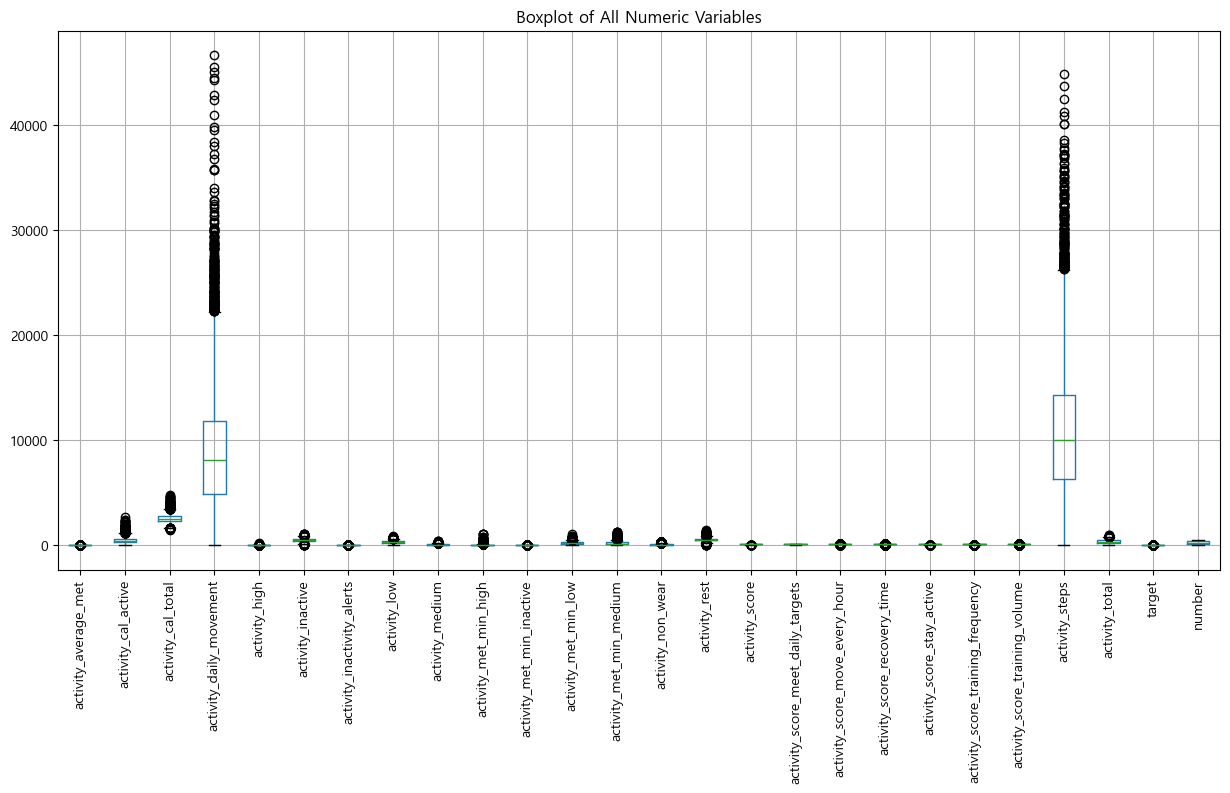

In [7]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_activity.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

- 데이터의 왜도 체크

In [8]:
from scipy.stats import skew
skewness = train_activity.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness)

Skewness for each column:
activity_average_met                 0.960751
activity_cal_active                  1.241112
activity_cal_total                   0.562600
activity_daily_movement              1.196831
activity_high                        7.406129
activity_inactive                    0.180745
activity_inactivity_alerts           2.105201
activity_low                         0.479395
activity_medium                      1.313342
activity_met_min_high                9.167017
activity_met_min_inactive            1.190537
activity_met_min_low                 1.078192
activity_met_min_medium              1.651317
activity_non_wear                    1.556458
activity_rest                        0.519608
activity_score                      -0.987259
activity_score_meet_daily_targets   -1.115499
activity_score_move_every_hour      -4.270279
activity_score_recovery_time        -2.222640
activity_score_stay_active          -0.802809
activity_score_training_frequency   -1.558001
activity

In [9]:
skewness.values

array([ 0.9607514 ,  1.24111211,  0.56260049,  1.19683106,  7.40612926,
        0.18074528,  2.10520094,  0.47939525,  1.31334208,  9.1670165 ,
        1.1905365 ,  1.07819161,  1.65131668,  1.55645834,  0.51960833,
       -0.98725898, -1.11549905, -4.27027881, -2.22264005, -0.80280939,
       -1.55800109, -1.89189264,  0.92313637,  0.38331421,  3.74953478,
        0.04389677])

In [10]:
#왜도값이 +0.5 이상인 데이터는 따로 전처리
activity_cols_log = list(skewness[skewness.values>0.5].index)
activity_cols_log.remove('target')

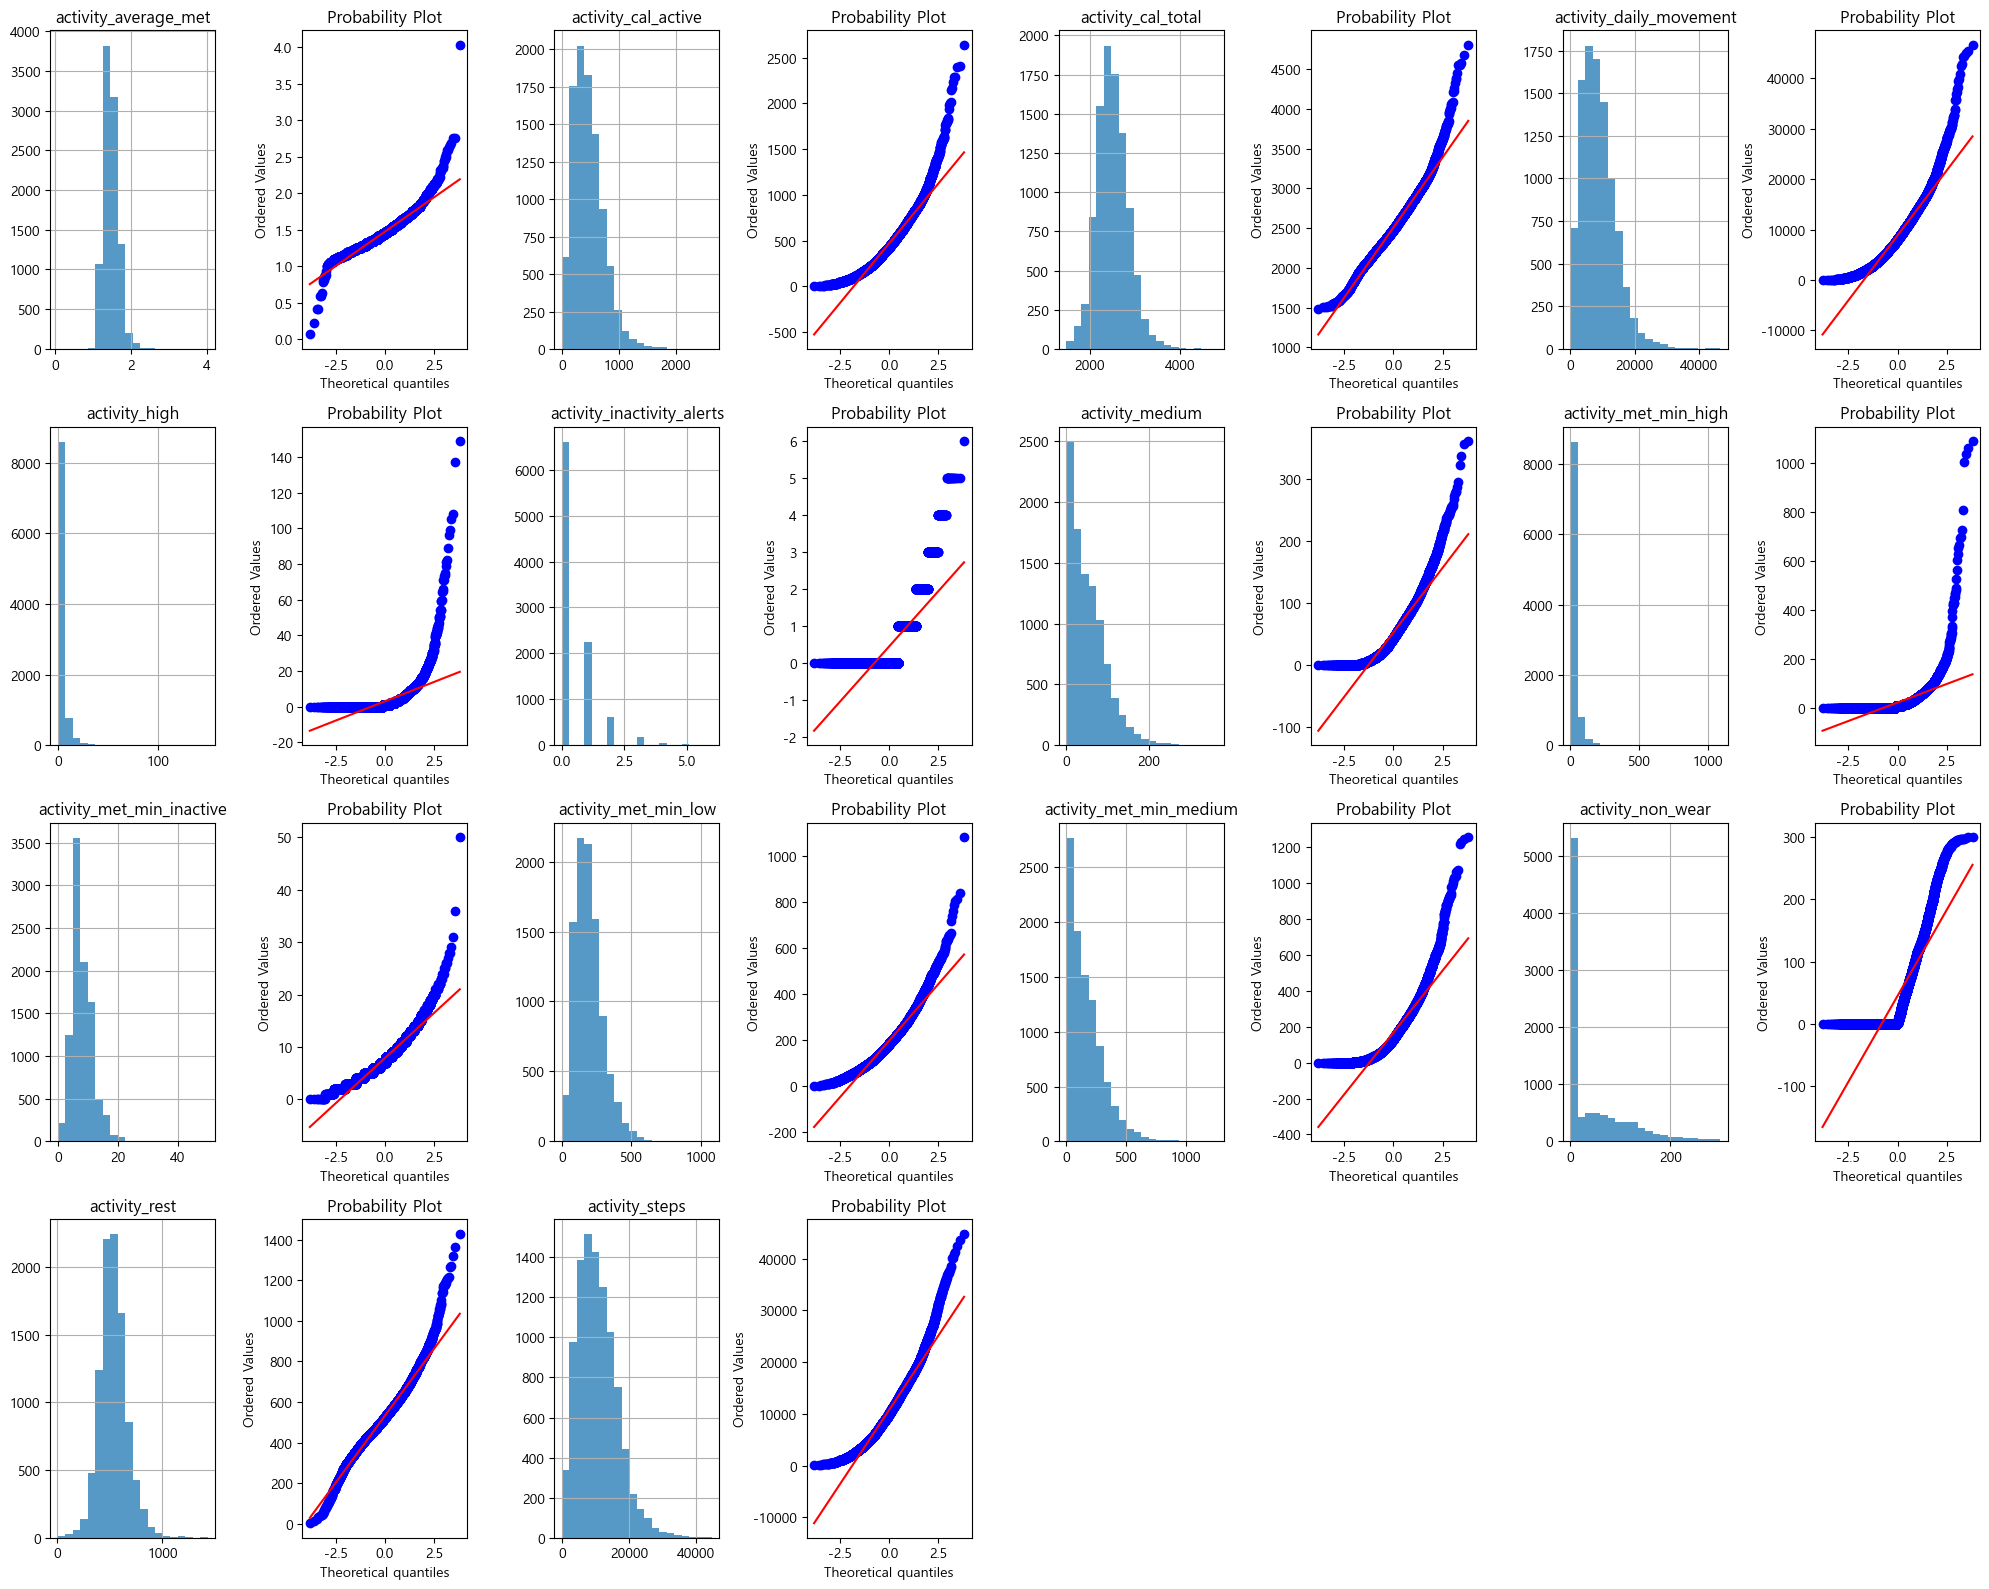

In [11]:
# 왜도값이 양수인 feature들의 데이터 분포 확인
num_cols = 4
num_rows = -(-len(activity_cols_log) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(activity_cols_log, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    train_activity[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(train_activity[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


In [12]:
# 0.5 이상은 왜도가 높은 -> 로그 변환으로 왜도 해소 시도
def log_transform(df, columns):
    for col in columns:
        # 1을 더한 후 Log Transformation 적용
        df[col] = np.log1p(df[col])

    return df

# 주어진 열에 Log Transformation 적용
df = log_transform(train_activity, activity_cols_log)

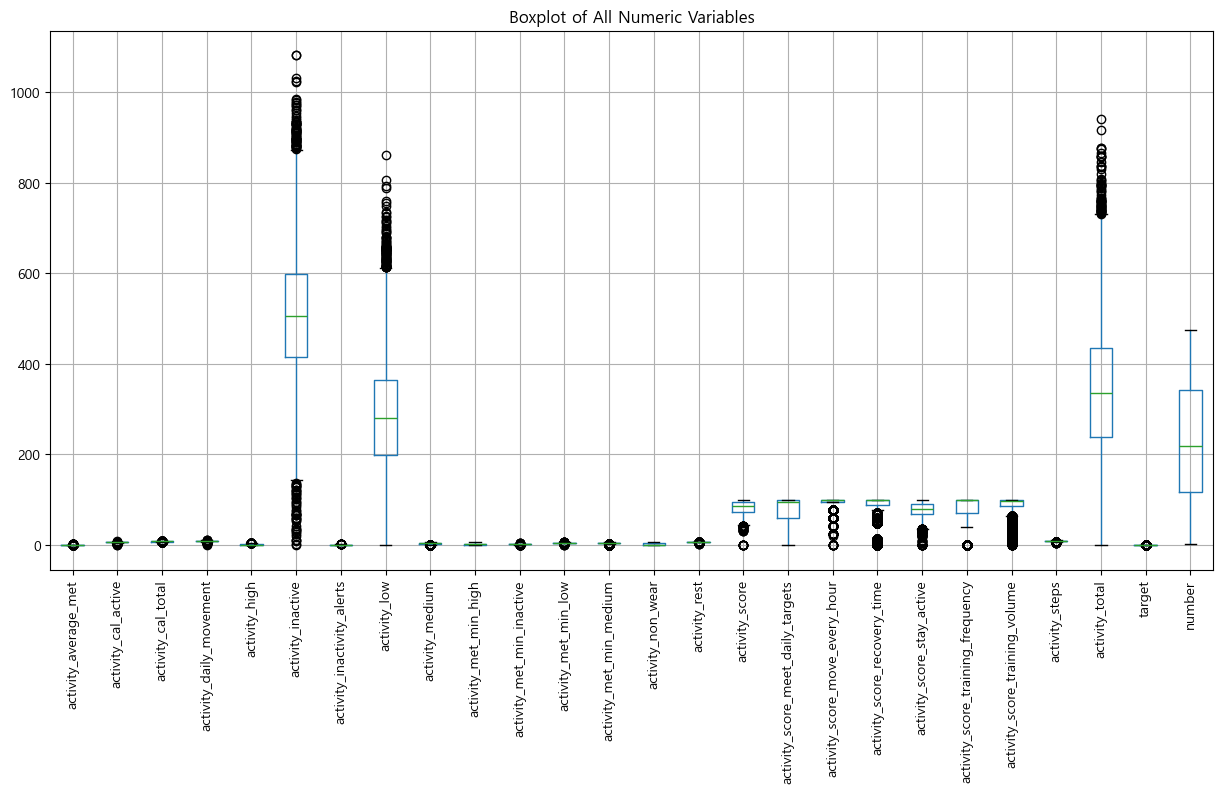

In [13]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_activity.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

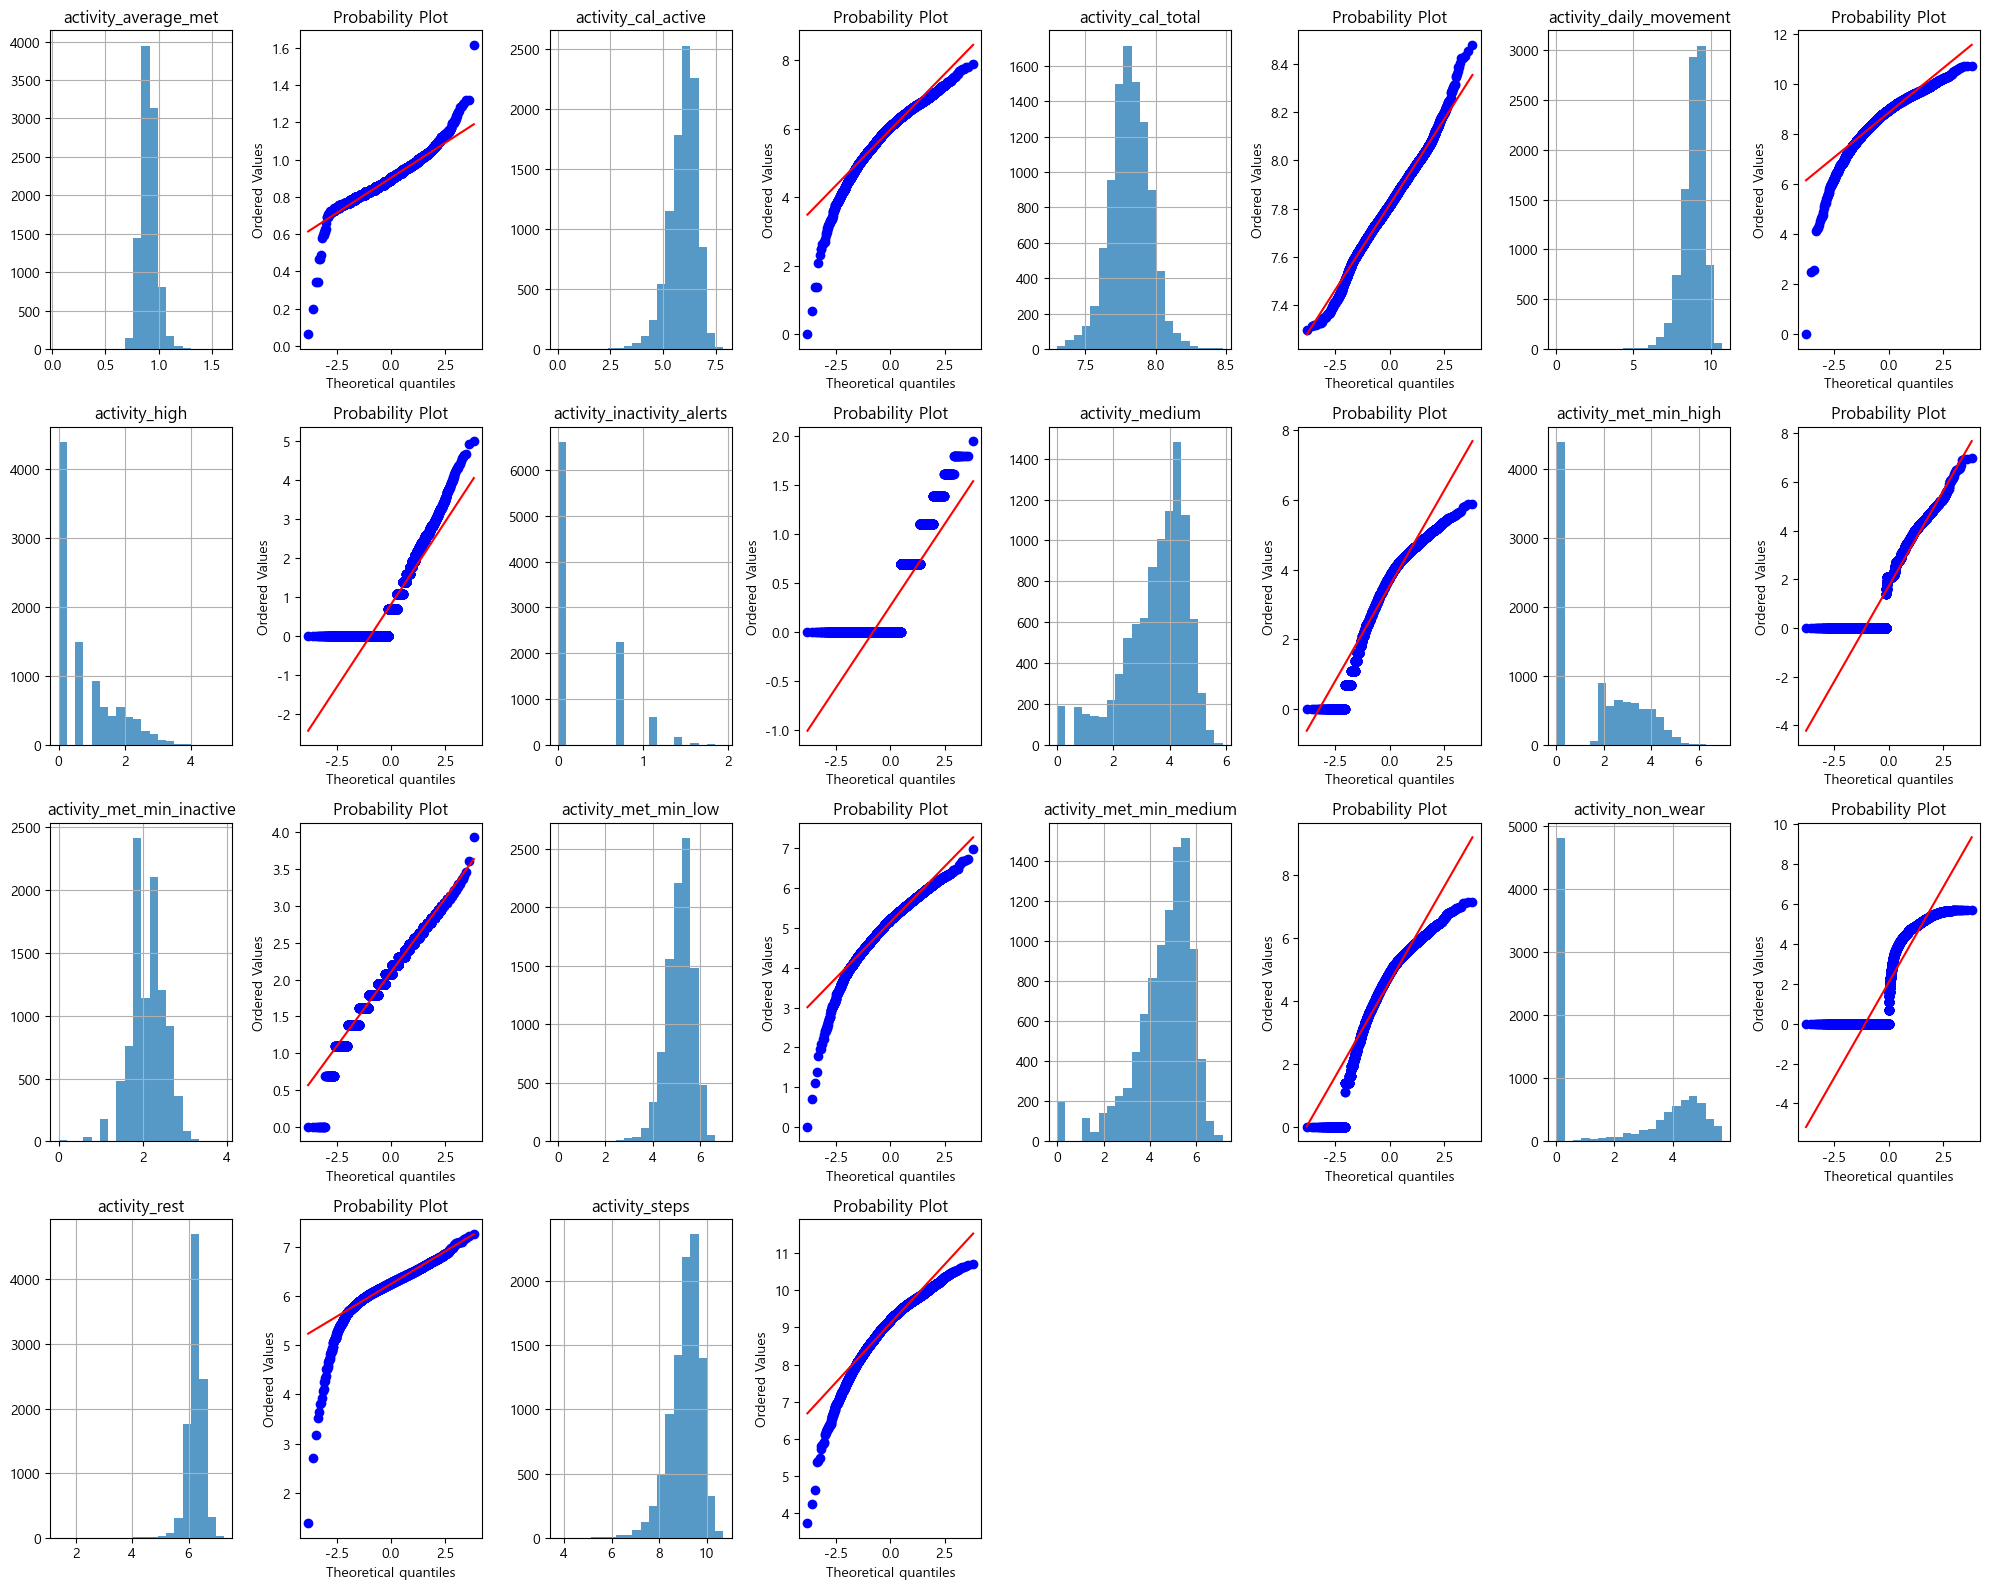

In [14]:
num_cols = 4
num_rows = -(-len(activity_cols_log) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(activity_cols_log, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    train_activity[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(train_activity[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


In [15]:
# 모든 열의 왜도 확인
skewness = df.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness)

Skewness for each column:
activity_average_met                 0.255714
activity_cal_active                 -1.037833
activity_cal_total                  -0.049029
activity_daily_movement             -1.399139
activity_high                        0.926930
activity_inactive                    0.180745
activity_inactivity_alerts           1.220707
activity_low                         0.479395
activity_medium                     -1.048599
activity_met_min_high                0.297805
activity_met_min_inactive           -0.376528
activity_met_min_low                -0.923463
activity_met_min_medium             -1.337566
activity_non_wear                    0.231480
activity_rest                       -2.131355
activity_score                      -0.987259
activity_score_meet_daily_targets   -1.115499
activity_score_move_every_hour      -4.270279
activity_score_recovery_time        -2.222640
activity_score_stay_active          -0.802809
activity_score_training_frequency   -1.558001
activity

In [16]:
skewness[skewness.values>0.5].index

Index(['activity_high', 'activity_inactivity_alerts', 'target'], dtype='object')

In [17]:
# 주어진 열들에 대해 0이나 음수값이 있는지 확인
columns_to_check = ['activity_high', 'activity_inactivity_alerts']

for col in columns_to_check:
    has_zero_or_negative = (df[col] <= 0).any()
    if has_zero_or_negative:
        print(f"{col} 열에 0이나 음수값이 존재합니다.")
    else:
        print(f"{col} 열에 0이나 음수값이 없습니다.")

activity_high 열에 0이나 음수값이 존재합니다.
activity_inactivity_alerts 열에 0이나 음수값이 존재합니다.


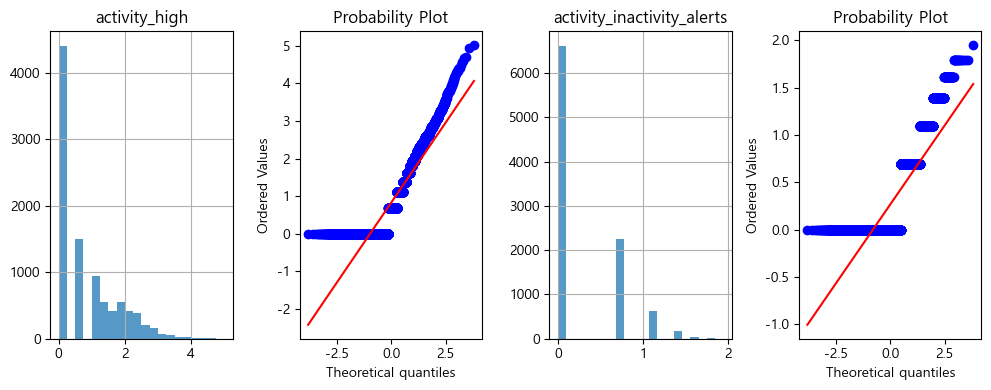

In [18]:
num_cols = 4
num_rows = -(-len(columns_to_check) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(columns_to_check, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    train_activity[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(train_activity[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


In [19]:
train_activity = df

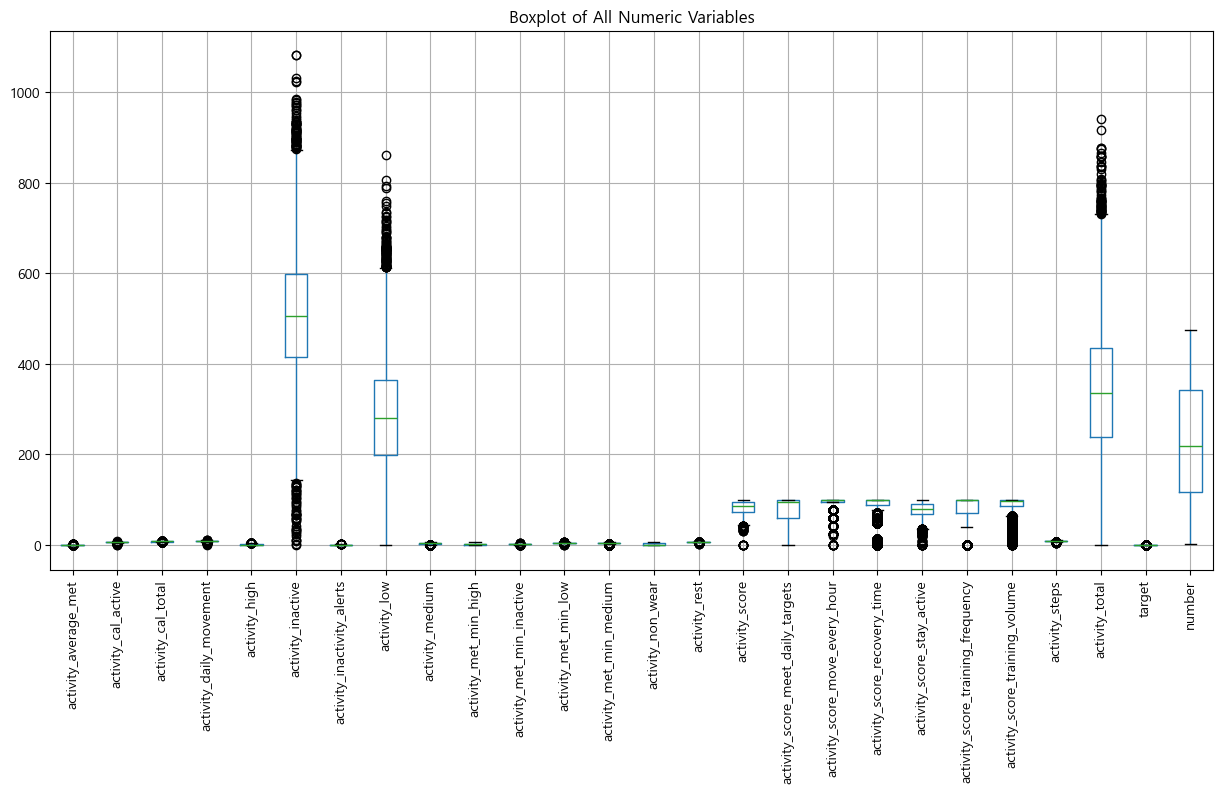

In [20]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_activity.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [43]:
activity_cols_minmax = ['activity_inactive', 'activity_low', 'activity_total']
activity_cols_robust = [col for col in train_activity.columns if col not in activity_cols_minmax]
activity_cols_robust.remove('number')
activity_cols_robust.remove('target')

In [22]:
print(len(activity_cols_minmax))
print(len(activity_cols_robust))
print(len(train_activity.columns))

3
23
26


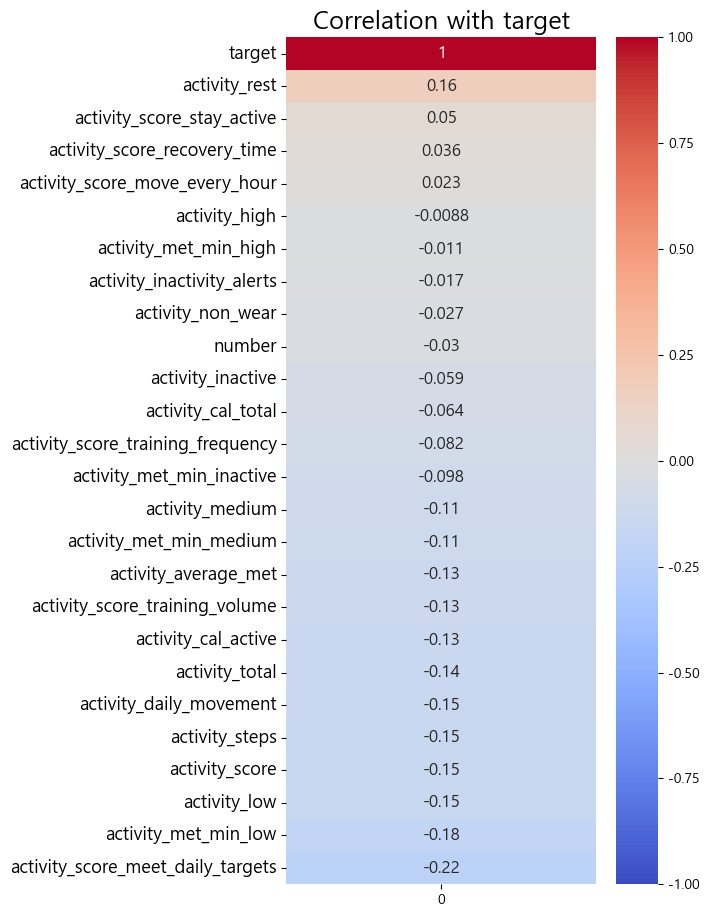

In [ ]:
# 문자열 열을 제외하고 숫자형 열만 선택
numeric_df = df.select_dtypes(include=[np.number])

# target과 다른 숫자형 변수들 간의 상관계수 계산
correlation_matrix = numeric_df.corr()

# target과 다른 변수들과의 상관계수만 선택
target_correlation = correlation_matrix['target'].sort_values(ascending=False)

# 상관관계 시각화를 위해 NumPy 배열로 변환
target_correlation_array = target_correlation.values.reshape(-1, 1)

# 상관관계 시각화
plt.figure(figsize=(5, 11))
sns.heatmap(target_correlation_array, annot=True, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=target_correlation.index, annot_kws={"size": 12})
plt.yticks(fontsize=13)
plt.title("Correlation with target", fontsize=18)
plt.show()

In [24]:
from scipy.stats import skew
skewness_sleep = train_sleep.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness_sleep)

Skewness for each column:
sleep_awake                    1.537876
sleep_breath_average          -0.183781
sleep_deep                     0.523582
sleep_duration                 0.516258
sleep_efficiency              -0.831787
sleep_hr_average               0.222999
sleep_hr_lowest                0.270056
sleep_is_longest                    NaN
sleep_light                    0.471835
sleep_midpoint_at_delta        3.946977
sleep_midpoint_time            0.834369
sleep_onset_latency            4.285766
sleep_period_id                1.297660
sleep_rem                      0.441750
sleep_restless                 0.459600
sleep_rmssd                    2.353779
sleep_score                   -0.548432
sleep_score_alignment         -2.420322
sleep_score_deep              -1.411289
sleep_score_disturbances      -0.043193
sleep_score_efficiency        -0.861214
sleep_score_latency           -1.773915
sleep_score_rem               -0.071837
sleep_score_total             -0.436557
sleep_temperat

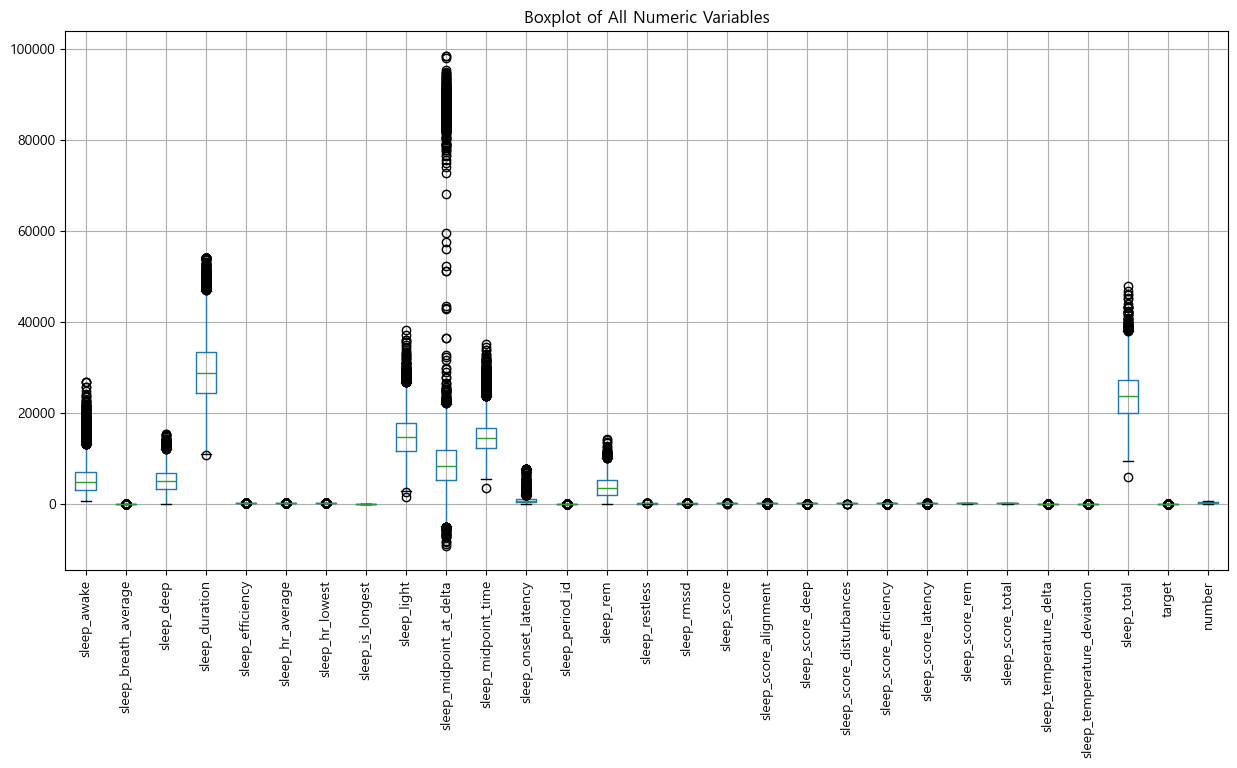

In [25]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_sleep.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [26]:
sleep_cols_log = list(skewness_sleep[skewness_sleep.values>0.5].index)
sleep_cols_log.remove('target')
# sleep_midpoint_at_delta는 음수가 섞여 있기 때문에 log변환 불가
sleep_cols_log.remove('sleep_midpoint_at_delta')

In [27]:
# 주어진 열에 Log Transformation 적용
df = log_transform(train_sleep, sleep_cols_log)

In [28]:
# 모든 열의 왜도 확인
skewness_sleep = df.apply(lambda x: skew(x))
print("Skewness for each column:")
print(skewness_sleep)

Skewness for each column:
sleep_awake                   -0.166364
sleep_breath_average          -0.183781
sleep_deep                    -2.278488
sleep_duration                -0.330791
sleep_efficiency              -0.831787
sleep_hr_average               0.222999
sleep_hr_lowest                0.270056
sleep_is_longest                    NaN
sleep_light                    0.471835
sleep_midpoint_at_delta        3.946977
sleep_midpoint_time           -0.201391
sleep_onset_latency           -0.518677
sleep_period_id                0.494600
sleep_rem                      0.441750
sleep_restless                 0.459600
sleep_rmssd                    0.550118
sleep_score                   -0.548432
sleep_score_alignment         -2.420322
sleep_score_deep              -1.411289
sleep_score_disturbances      -0.043193
sleep_score_efficiency        -0.861214
sleep_score_latency           -1.773915
sleep_score_rem               -0.071837
sleep_score_total             -0.436557
sleep_temperat

In [29]:
skewness_sleep[skewness_sleep.values>0.5].index

Index(['sleep_midpoint_at_delta', 'sleep_rmssd', 'target'], dtype='object')

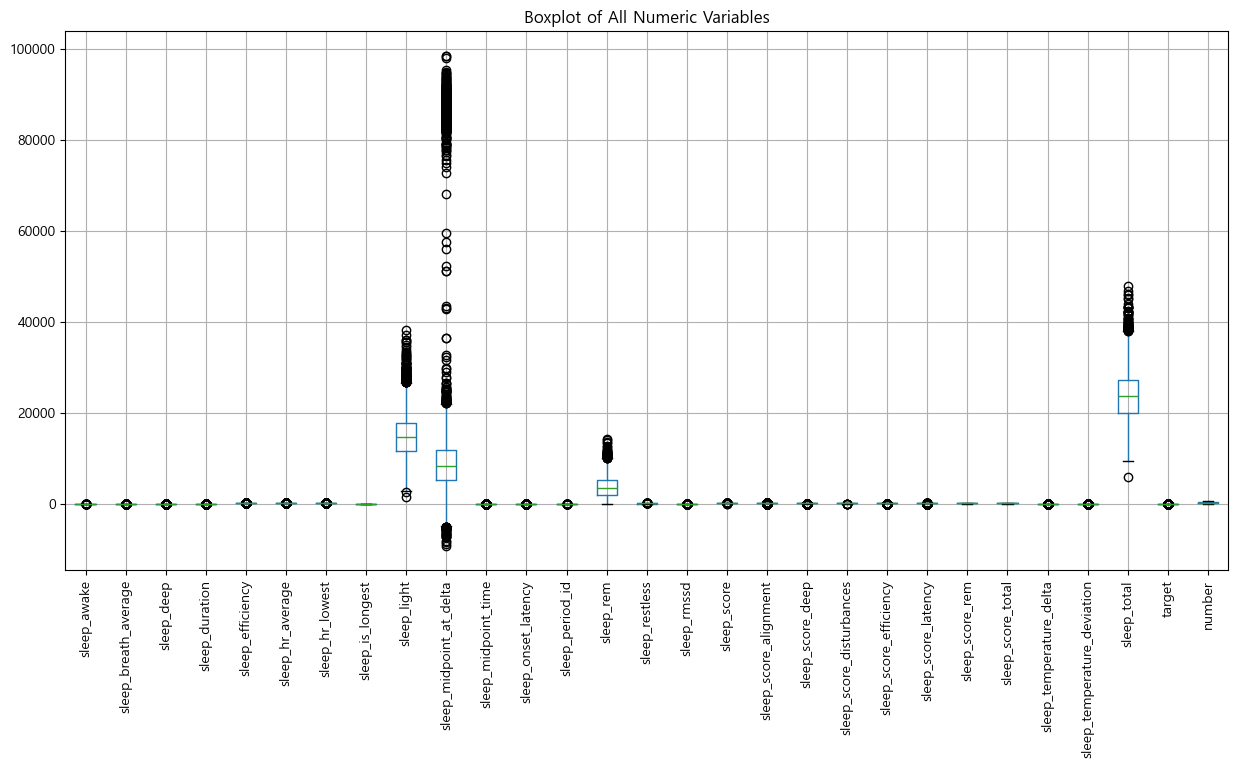

In [30]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
train_sleep.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [31]:
sleep_cols_power = ['sleep_midpoint_at_delta']
sleep_cols_minmax = ['sleep_light', 'sleep_rem', 'sleep_total']
sleep_cols_robust = [col for col in train_sleep.columns if col not in sleep_cols_minmax]
sleep_cols_robust.remove('sleep_midpoint_at_delta')
sleep_cols_robust.remove('number')
sleep_cols_robust.remove('target')

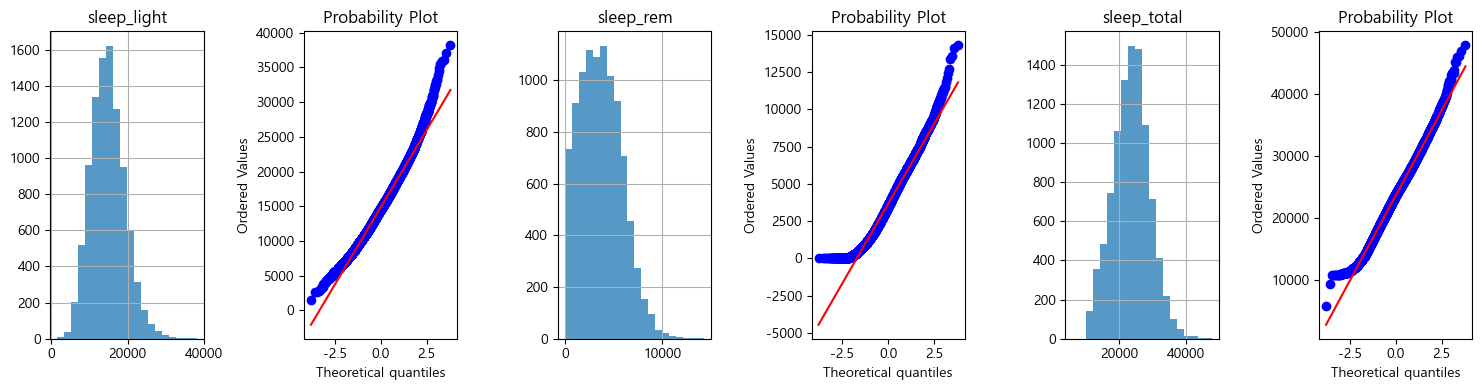

In [32]:
num_cols = 4
num_rows = -(-len(sleep_cols_minmax) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(sleep_cols_minmax, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    train_sleep[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(train_sleep[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


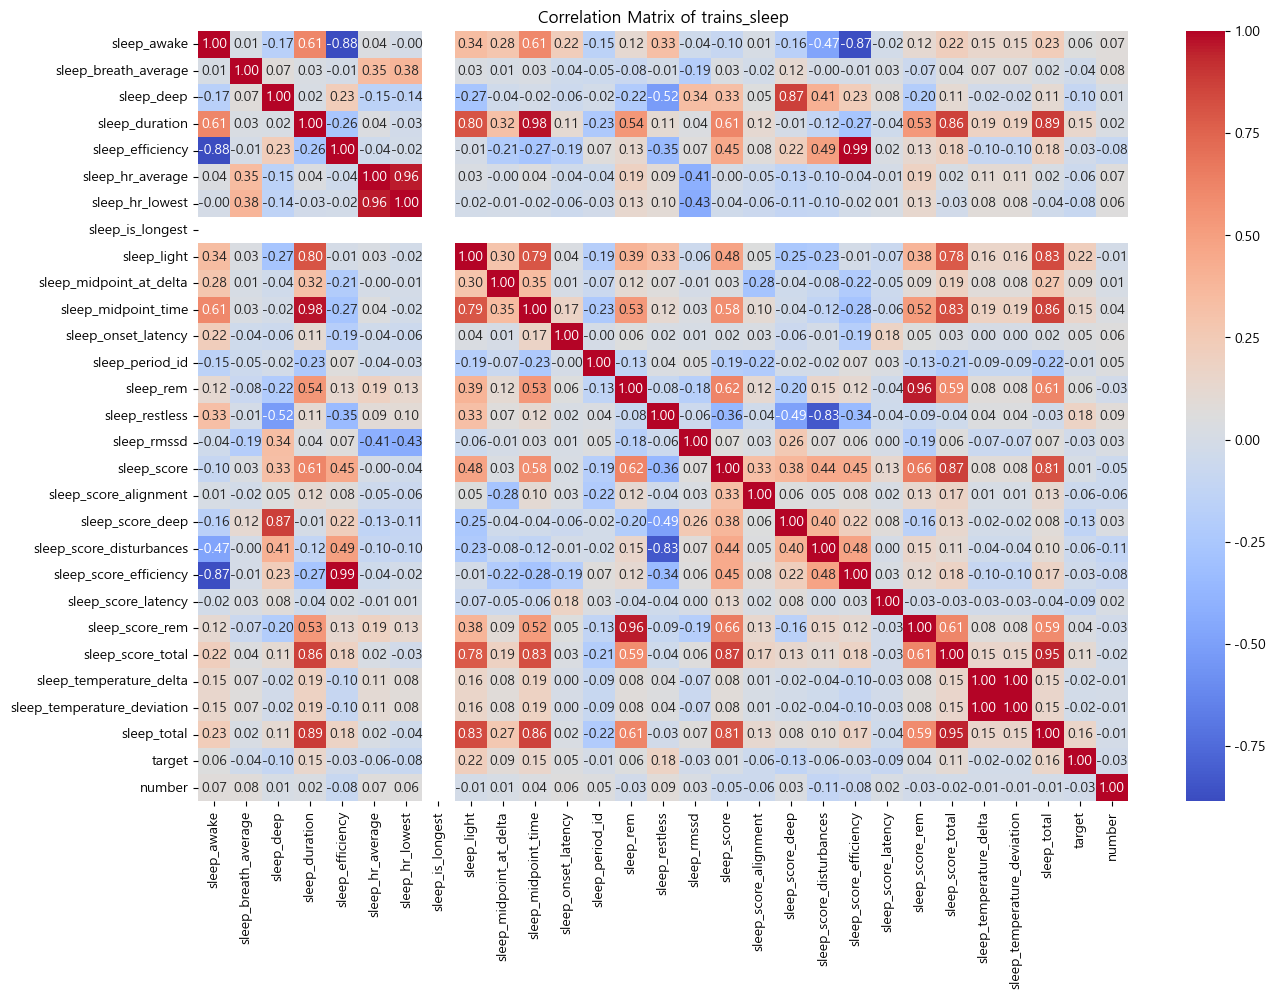

In [33]:
# correlatino으로 variable select
train_sleep_corr = train_sleep.copy()

plt.figure(figsize=(15,10))
sns.heatmap(train_sleep_corr.corr(), annot=True, fmt='.2f',cmap='coolwarm')
plt.title('Correlation Matrix of trains_sleep')
plt.show()

In [ ]:
# 음수가 섞여있던 ['sleep_midpoint_at_delta']는 yeo-johnson transformation
df[['sleep_midpoint_at_delta']]=power_transform(df[['sleep_midpoint_at_delta']], standardize=True)

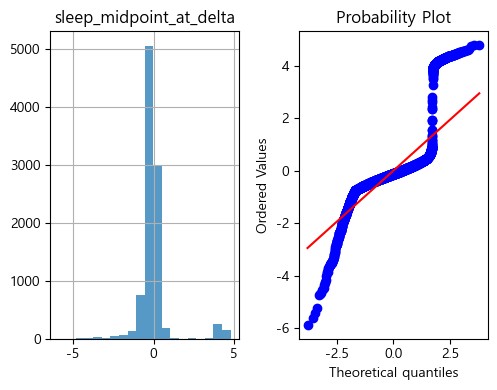

In [35]:
num_cols = 4
num_rows = -(-len(sleep_cols_power) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(sleep_cols_power, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    train_sleep[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(train_sleep[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


In [36]:
train_sleep = df

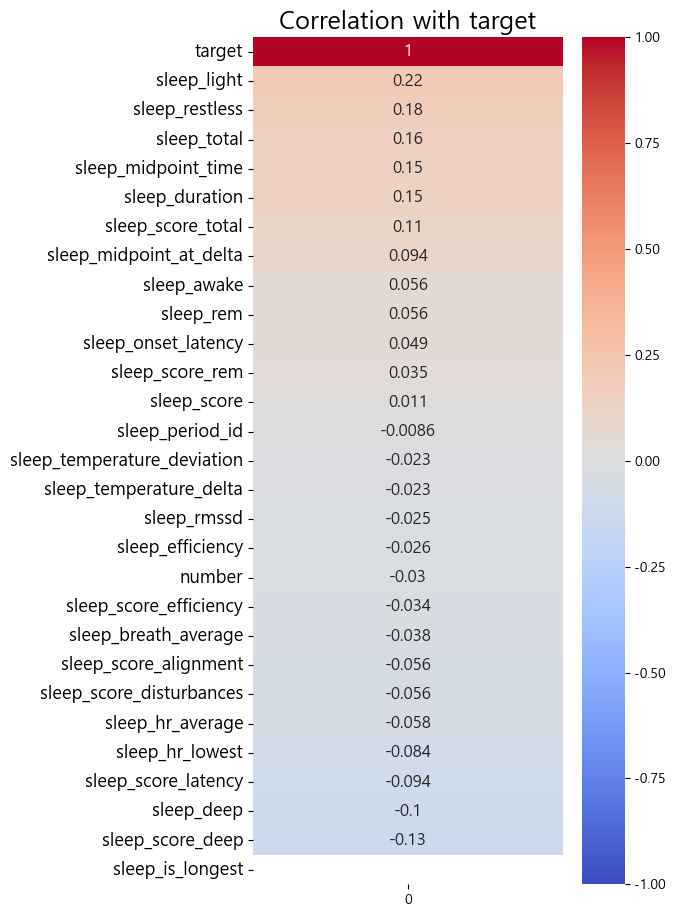

In [37]:
# 문자열 열을 제외하고 숫자형 열만 선택
numeric_df = df.select_dtypes(include=[np.number])

# 대기시간('CI_HOUR')과 다른 숫자형 변수들 간의 상관계수 계산
correlation_matrix = numeric_df.corr()

# 대기시간('target')과 다른 변수들과의 상관계수만 선택
target_correlation = correlation_matrix['target'].sort_values(ascending=False)

# 상관관계 시각화를 위해 NumPy 배열로 변환
target_correlation_array = target_correlation.values.reshape(-1, 1)

# 상관관계 시각화
plt.figure(figsize=(5, 11))
sns.heatmap(target_correlation_array, annot=True, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=target_correlation.index, annot_kws={"size":12})
plt.yticks(fontsize=13)
plt.title("Correlation with target", fontsize=18)
plt.show()

In [38]:
train = pd.concat([train_activity, train_sleep.loc[:, ~train_sleep.columns.isin(train_activity.columns)]], axis=1)

In [39]:
for col in activity_cols_log:
    test[col] = np.log1p(test[col].clip(lower=0))

for col in sleep_cols_log:
    test[col] = np.log1p(test[col].clip(lower=0))

test[sleep_cols_power] = power_transform(test[['sleep_midpoint_at_delta']], standardize=True)

실험 1. activity data로 학습

In [93]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train_activity.drop(columns=['target', 'number'])
y_train = train_activity['target']

X_val = val_activity.drop(columns=['target', 'number'])
y_val = val_activity['target']

                              Feature  Importance
14                      activity_rest    0.083919
21     activity_score_training_volume    0.068574
7                        activity_low    0.056464
3             activity_daily_movement    0.056186
11               activity_met_min_low    0.054210
2                  activity_cal_total    0.053624
1                 activity_cal_active    0.051698
22                     activity_steps    0.049837
23                     activity_total    0.049680
15                     activity_score    0.049172
12            activity_met_min_medium    0.047602
5                   activity_inactive    0.047153
16  activity_score_meet_daily_targets    0.046235
19         activity_score_stay_active    0.042371
8                     activity_medium    0.041538
10          activity_met_min_inactive    0.034364
9               activity_met_min_high    0.033636
0                activity_average_met    0.033415
13                  activity_non_wear    0.027038


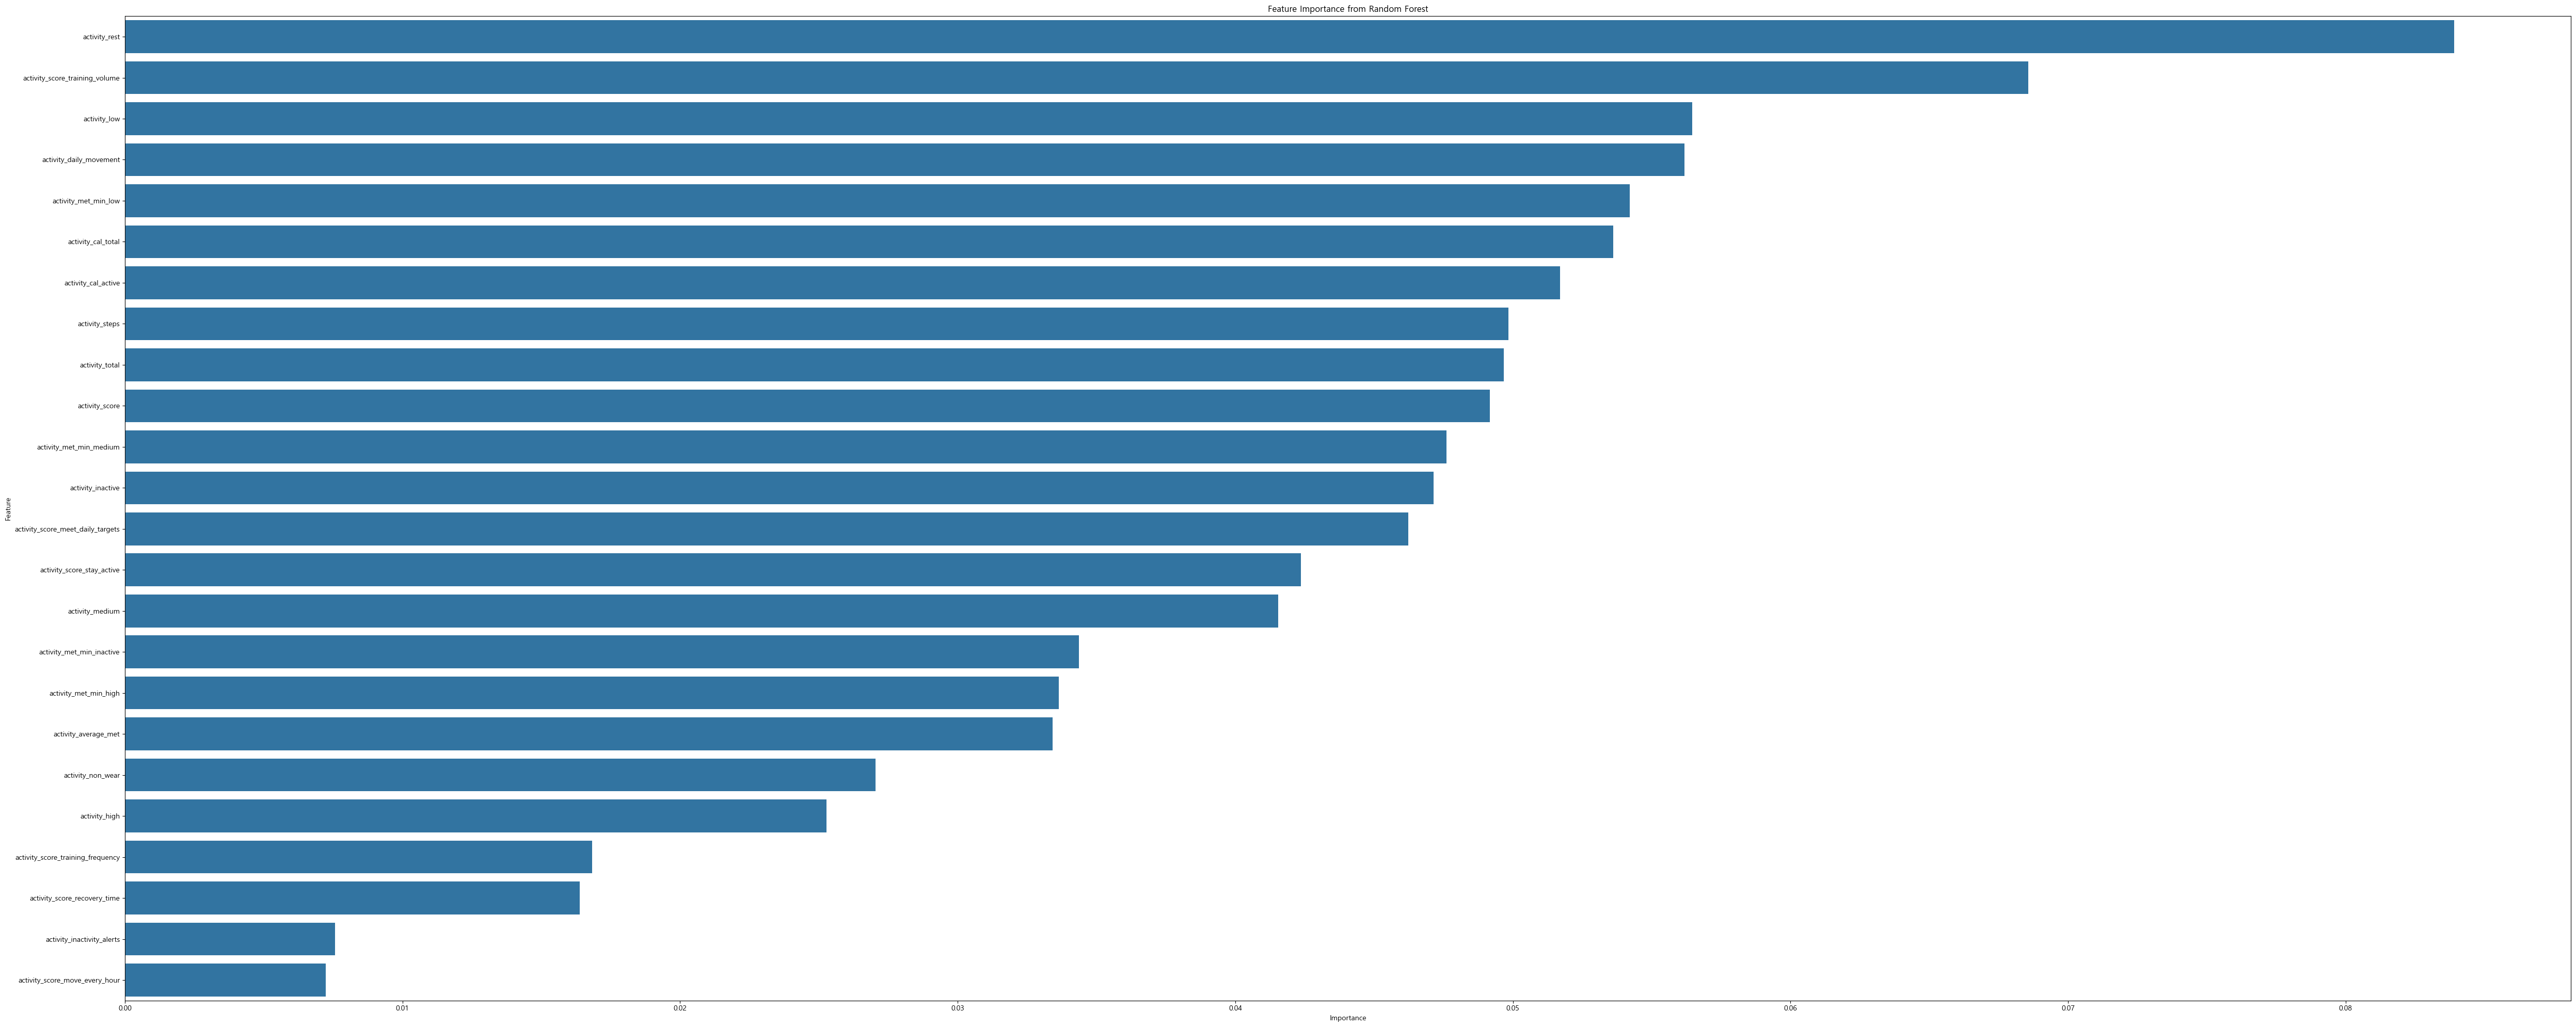

Validation Accuracy: 0.91


In [94]:
# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

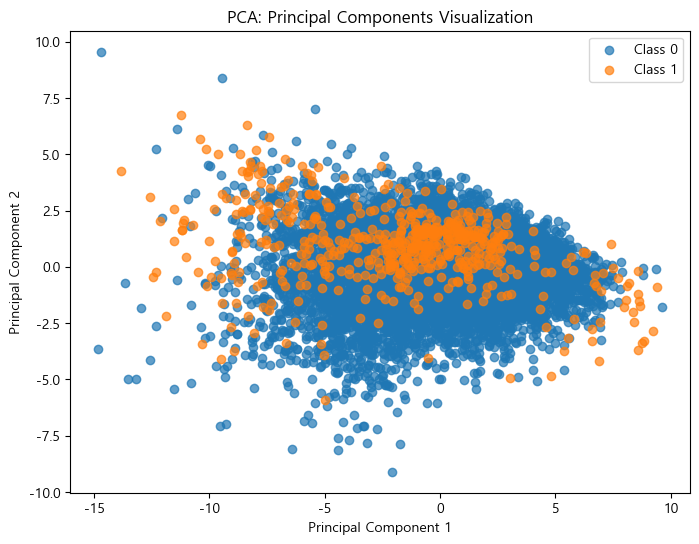

Explained Variance Ratio: [0.45110217 0.11215227]


In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [96]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['activity_rest', 'activity_score_training_volume', 'activity_low', 'activity_daily_movement', 'activity_met_min_low', 'activity_cal_total', 'activity_cal_active', 'activity_steps', 'activity_total', 'activity_score']


In [97]:
X_train = train_activity[top_features]
y_train = train_activity["target"]
X_test = val_activity[top_features]
y_test = val_activity["target"]

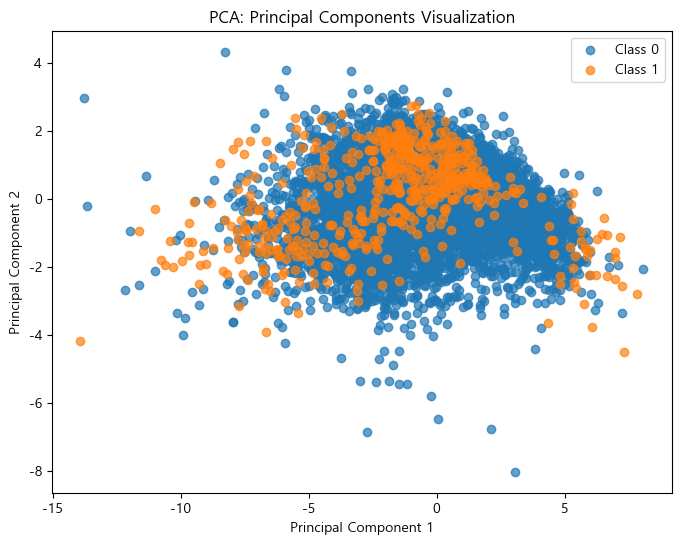

Explained Variance Ratio: [0.66661199 0.13223858]


In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

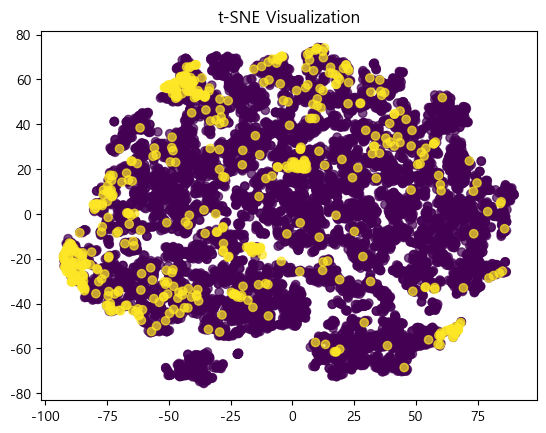

In [53]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [102]:
cols_minmax = [col for col in top_features if col in activity_cols_minmax]
cols_robust = [col for col in top_features if col in activity_cols_robust]
print(cols_minmax)
print(cols_robust)

['activity_low', 'activity_total']
['activity_rest', 'activity_score_training_volume', 'activity_daily_movement', 'activity_met_min_low', 'activity_cal_total', 'activity_cal_active', 'activity_steps', 'activity_score']


In [103]:
sc_minmax = MinMaxScaler()
sc_robust = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_minmax] = sc_minmax.fit_transform(X_train[cols_minmax])
X_test_scaled[cols_minmax] = sc_minmax.transform(X_val[cols_minmax])

X_train_scaled[cols_robust] = sc_robust.fit_transform(X_train[cols_robust])
X_test_scaled[cols_robust] = sc_robust.transform(X_test[cols_robust])


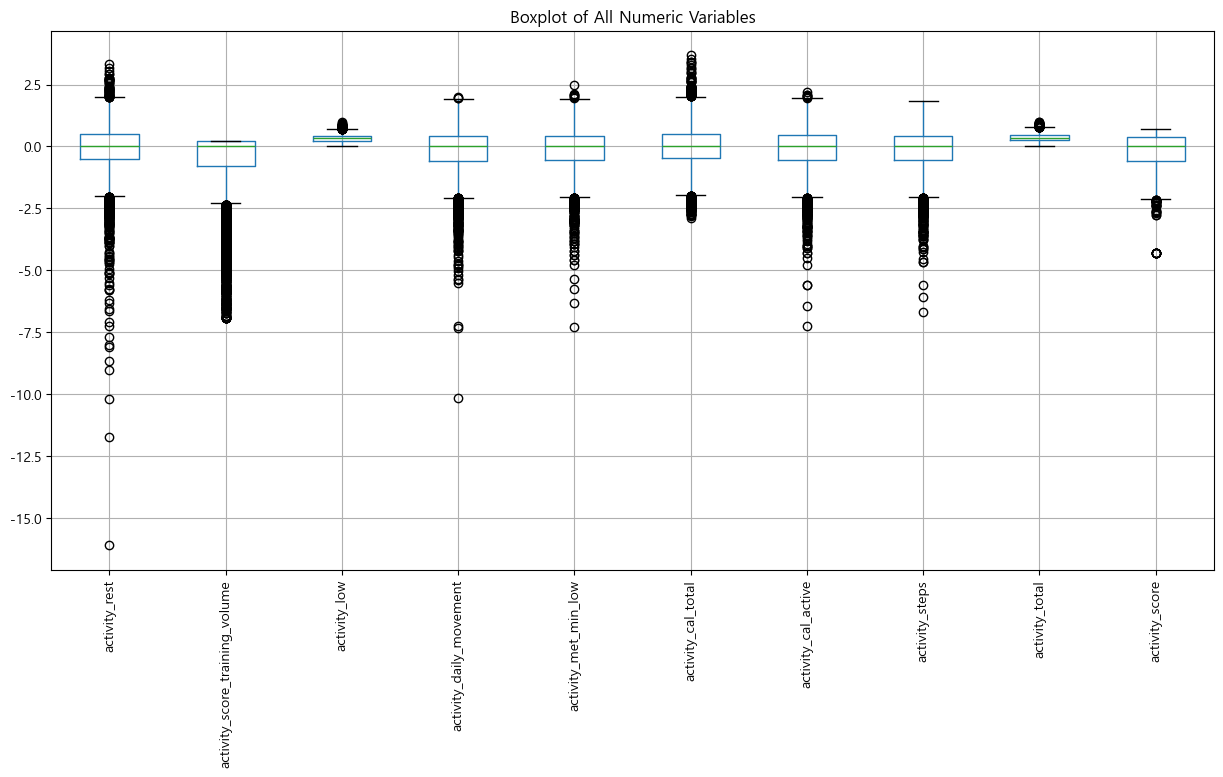

In [104]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
X_train_scaled.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [105]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_scaled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.189589
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.1527
Time:                        14:50:16   Log-Likelihood:                -1840.0
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                5.223e-136
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.8430      0.379     -7.507     

- 로직스틱 회귀

In [106]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_scaled, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.2687651331719128
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.35      2264
           1       0.09      0.86      0.17       214

    accuracy                           0.27      2478
   macro avg       0.52      0.54      0.26      2478
weighted avg       0.87      0.27      0.33      2478

Confusion Matrix:
 [[ 481 1783]
 [  29  185]]


- 나이브 베이즈

In [107]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test_scaled)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.08635996771589992
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2264
           1       0.09      1.00      0.16       214

    accuracy                           0.09      2478
   macro avg       0.04      0.50      0.08      2478
weighted avg       0.01      0.09      0.01      2478

Confusion Matrix:
 [[   0 2264]
 [   0  214]]


- XGBoost

In [108]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9100080710250201
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      2264
           1       0.09      0.00      0.01       214

    accuracy                           0.91      2478
   macro avg       0.50      0.50      0.48      2478
weighted avg       0.84      0.91      0.87      2478

Confusion Matrix:
 [[2254   10]
 [ 213    1]]


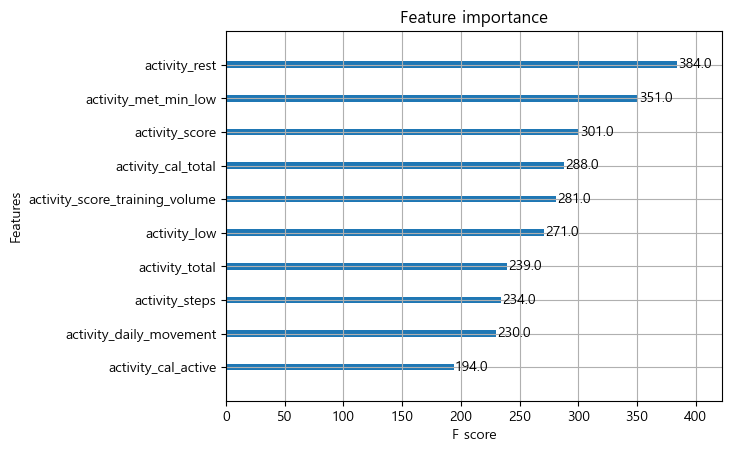

In [109]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [110]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_scaled, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2205
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.884180790960452
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2264
           1       0.01      0.00      0.01       214

    accuracy                           0.88      2478
   macro avg       0.46      0.49      0.47      2478
weighted avg       0.83      0.88      0.86      2478

Confusion Matrix:
 [[2190   74]
 [ 213    1]]


- Decision Tree

In [111]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test_scaled)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8890234059725585
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2264
           1       0.02      0.00      0.01       214

    accuracy                           0.89      2478
   macro avg       0.46      0.49      0.47      2478
weighted avg       0.83      0.89      0.86      2478

Confusion Matrix:
 [[2202   62]
 [ 213    1]]


2. sleep data로 학습

                        Feature  Importance
6               sleep_hr_lowest    0.067943
5              sleep_hr_average    0.058722
1          sleep_breath_average    0.057918
14               sleep_restless    0.054063
19     sleep_score_disturbances    0.052954
8                   sleep_light    0.052256
26                  sleep_total    0.046335
9       sleep_midpoint_at_delta    0.046241
15                  sleep_rmssd    0.043749
10          sleep_midpoint_time    0.038632
0                   sleep_awake    0.038042
13                    sleep_rem    0.037127
3                sleep_duration    0.036016
2                    sleep_deep    0.035424
18             sleep_score_deep    0.034935
11          sleep_onset_latency    0.032652
22              sleep_score_rem    0.031782
24      sleep_temperature_delta    0.031028
16                  sleep_score    0.030966
25  sleep_temperature_deviation    0.030813
23            sleep_score_total    0.030761
4              sleep_efficiency 

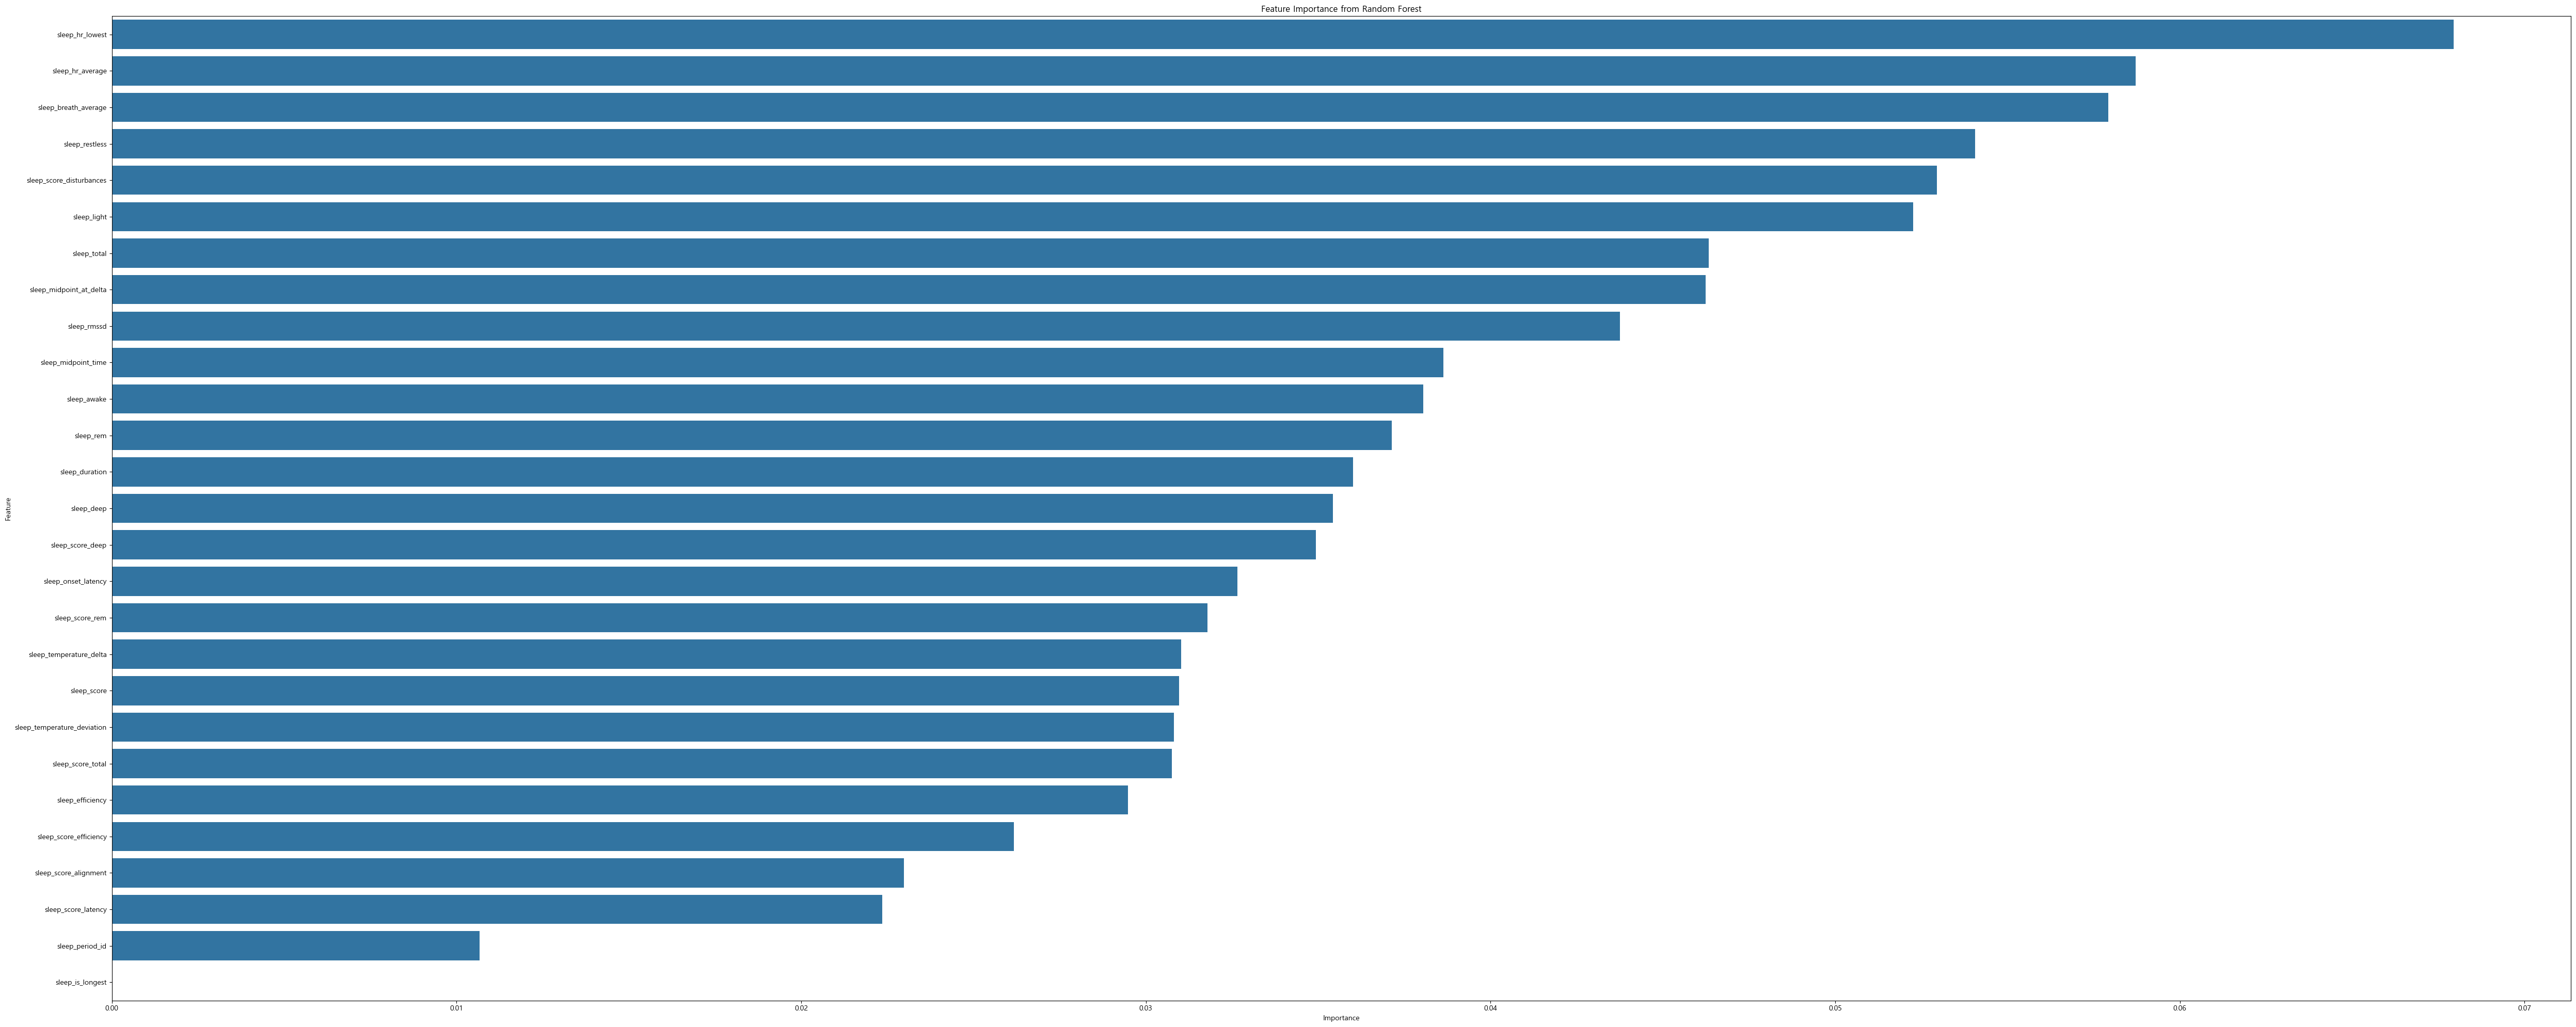

Validation Accuracy: 0.92


In [112]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train_sleep.drop(columns=['target', 'number'])
y_train = train_sleep['target']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = val_sleep.drop(columns=['target', 'number'])
y_val = val_sleep['target']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

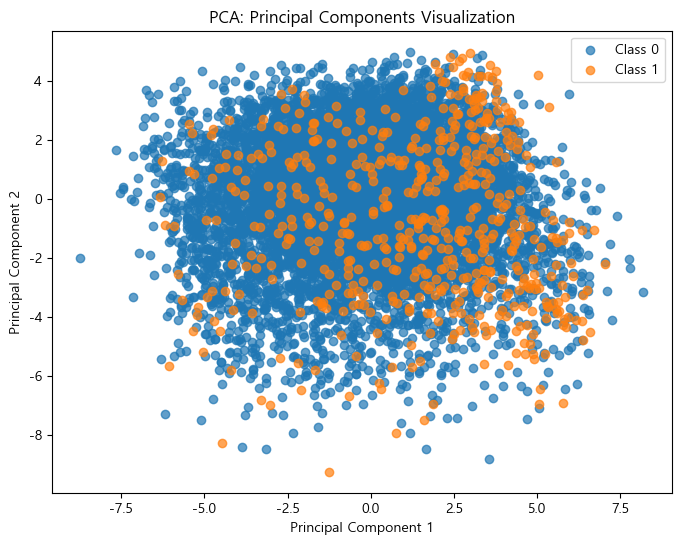

Explained Variance Ratio: [0.24354022 0.17499897]


In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [114]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['sleep_hr_lowest', 'sleep_hr_average', 'sleep_breath_average', 'sleep_restless', 'sleep_score_disturbances', 'sleep_light', 'sleep_total', 'sleep_midpoint_at_delta', 'sleep_rmssd', 'sleep_midpoint_time']


In [115]:
X_train = train_sleep[top_features]
y_train = train_sleep["target"]
X_test = val_sleep[top_features]
y_test = val_sleep["target"]

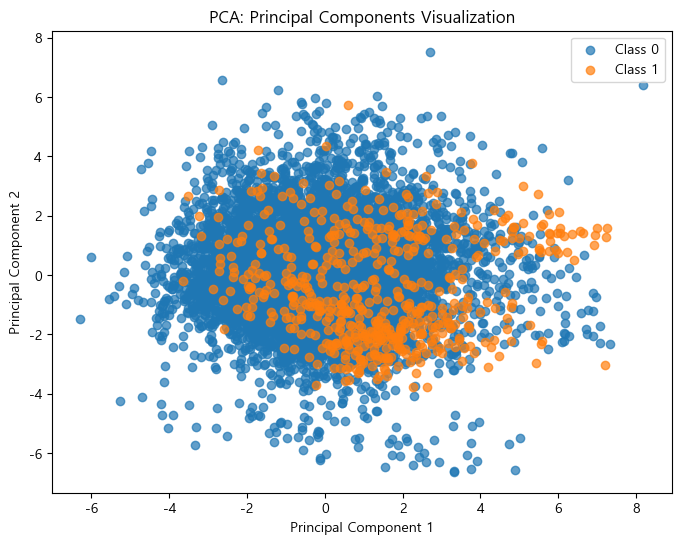

Explained Variance Ratio: [0.29226558 0.2499935 ]


In [116]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

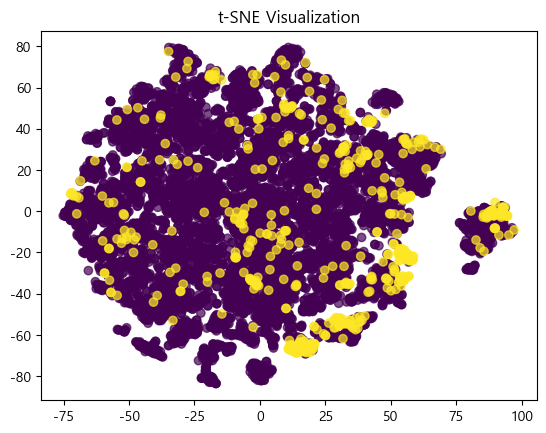

In [71]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [118]:
cols_minmax = [col for col in top_features if col in sleep_cols_minmax]
cols_robust = [col for col in top_features if col in sleep_cols_robust]
print(cols_minmax)
print(cols_robust)

['sleep_light', 'sleep_total']
['sleep_hr_lowest', 'sleep_hr_average', 'sleep_breath_average', 'sleep_restless', 'sleep_score_disturbances', 'sleep_rmssd', 'sleep_midpoint_time']


In [119]:
sc_minmax = MinMaxScaler()
sc_robust = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_minmax] = sc_minmax.fit_transform(X_train[cols_minmax])
X_test_scaled[cols_minmax] = sc_minmax.transform(X_val[cols_minmax])

X_train_scaled[cols_robust] = sc_robust.fit_transform(X_train[cols_robust])
X_test_scaled[cols_robust] = sc_robust.transform(X_test[cols_robust])


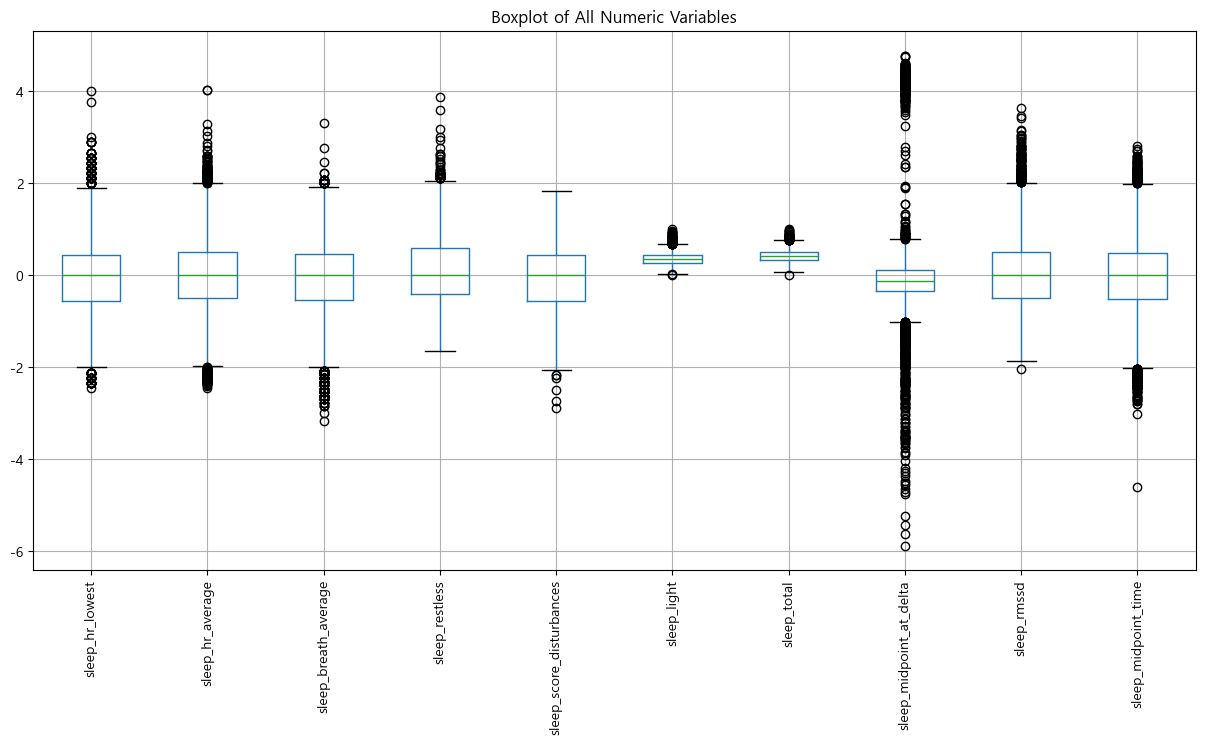

In [120]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
X_train_scaled.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [121]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_scaled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.175895
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.2139
Time:                        14:52:17   Log-Likelihood:                -1707.1
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                3.826e-193
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.1921      0.316    -16.441      0.000      -5.811

- 로지스틱 회귀

In [122]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_scaled, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.08635996771589992
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2264
           1       0.09      1.00      0.16       214

    accuracy                           0.09      2478
   macro avg       0.04      0.50      0.08      2478
weighted avg       0.01      0.09      0.01      2478

Confusion Matrix:
 [[   0 2264]
 [   0  214]]


- 나이브 베이즈

In [123]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test_scaled)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.08635996771589992
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2264
           1       0.09      1.00      0.16       214

    accuracy                           0.09      2478
   macro avg       0.04      0.50      0.08      2478
weighted avg       0.01      0.09      0.01      2478

Confusion Matrix:
 [[   0 2264]
 [   0  214]]


- XGBoost

In [124]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9196933010492333
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2264
           1       0.89      0.08      0.15       214

    accuracy                           0.92      2478
   macro avg       0.91      0.54      0.55      2478
weighted avg       0.92      0.92      0.89      2478

Confusion Matrix:
 [[2262    2]
 [ 197   17]]


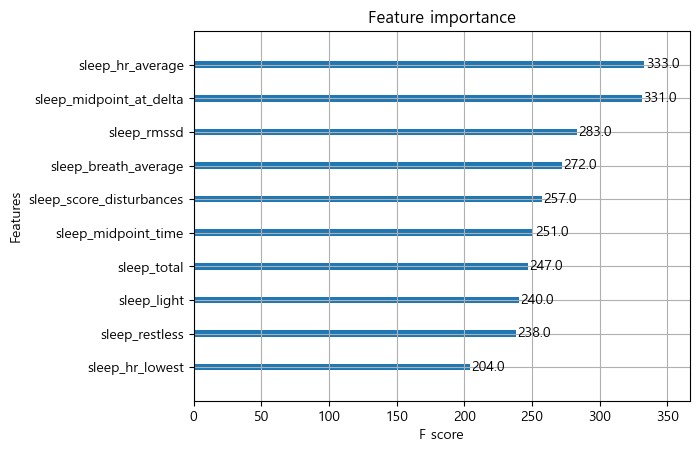

In [125]:
plot_importance(xgb_model)
plt.show()

- LigthGBM

In [126]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=100,learning_rate=0.01, random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_scaled, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.8075060532687651
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      2264
           1       0.24      0.57      0.34       214

    accuracy                           0.81      2478
   macro avg       0.60      0.70      0.61      2478
weighted avg       0.89      0.81      0.84      2478

Confusion Matrix:
 [[1879  385]
 [  92  122]]


- Decision Tree

In [127]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test_scaled)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8555286521388217
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      2264
           1       0.07      0.06      0.06       214

    accuracy                           0.86      2478
   macro avg       0.49      0.49      0.49      2478
weighted avg       0.84      0.86      0.85      2478

Confusion Matrix:
 [[2108  156]
 [ 202   12]]


3. activity + sleep으로 학습

                              Feature  Importance
30                    sleep_hr_lowest    0.044646
14                      activity_rest    0.038597
32                        sleep_light    0.037914
21     activity_score_training_volume    0.034849
25               sleep_breath_average    0.033066
29                   sleep_hr_average    0.032892
50                        sleep_total    0.029310
3             activity_daily_movement    0.028700
38                     sleep_restless    0.028306
43           sleep_score_disturbances    0.028031
7                        activity_low    0.026736
37                          sleep_rem    0.026676
11               activity_met_min_low    0.025549
16  activity_score_meet_daily_targets    0.023408
42                   sleep_score_deep    0.023334
34                sleep_midpoint_time    0.022739
33            sleep_midpoint_at_delta    0.022080
39                        sleep_rmssd    0.022016
22                     activity_steps    0.021911


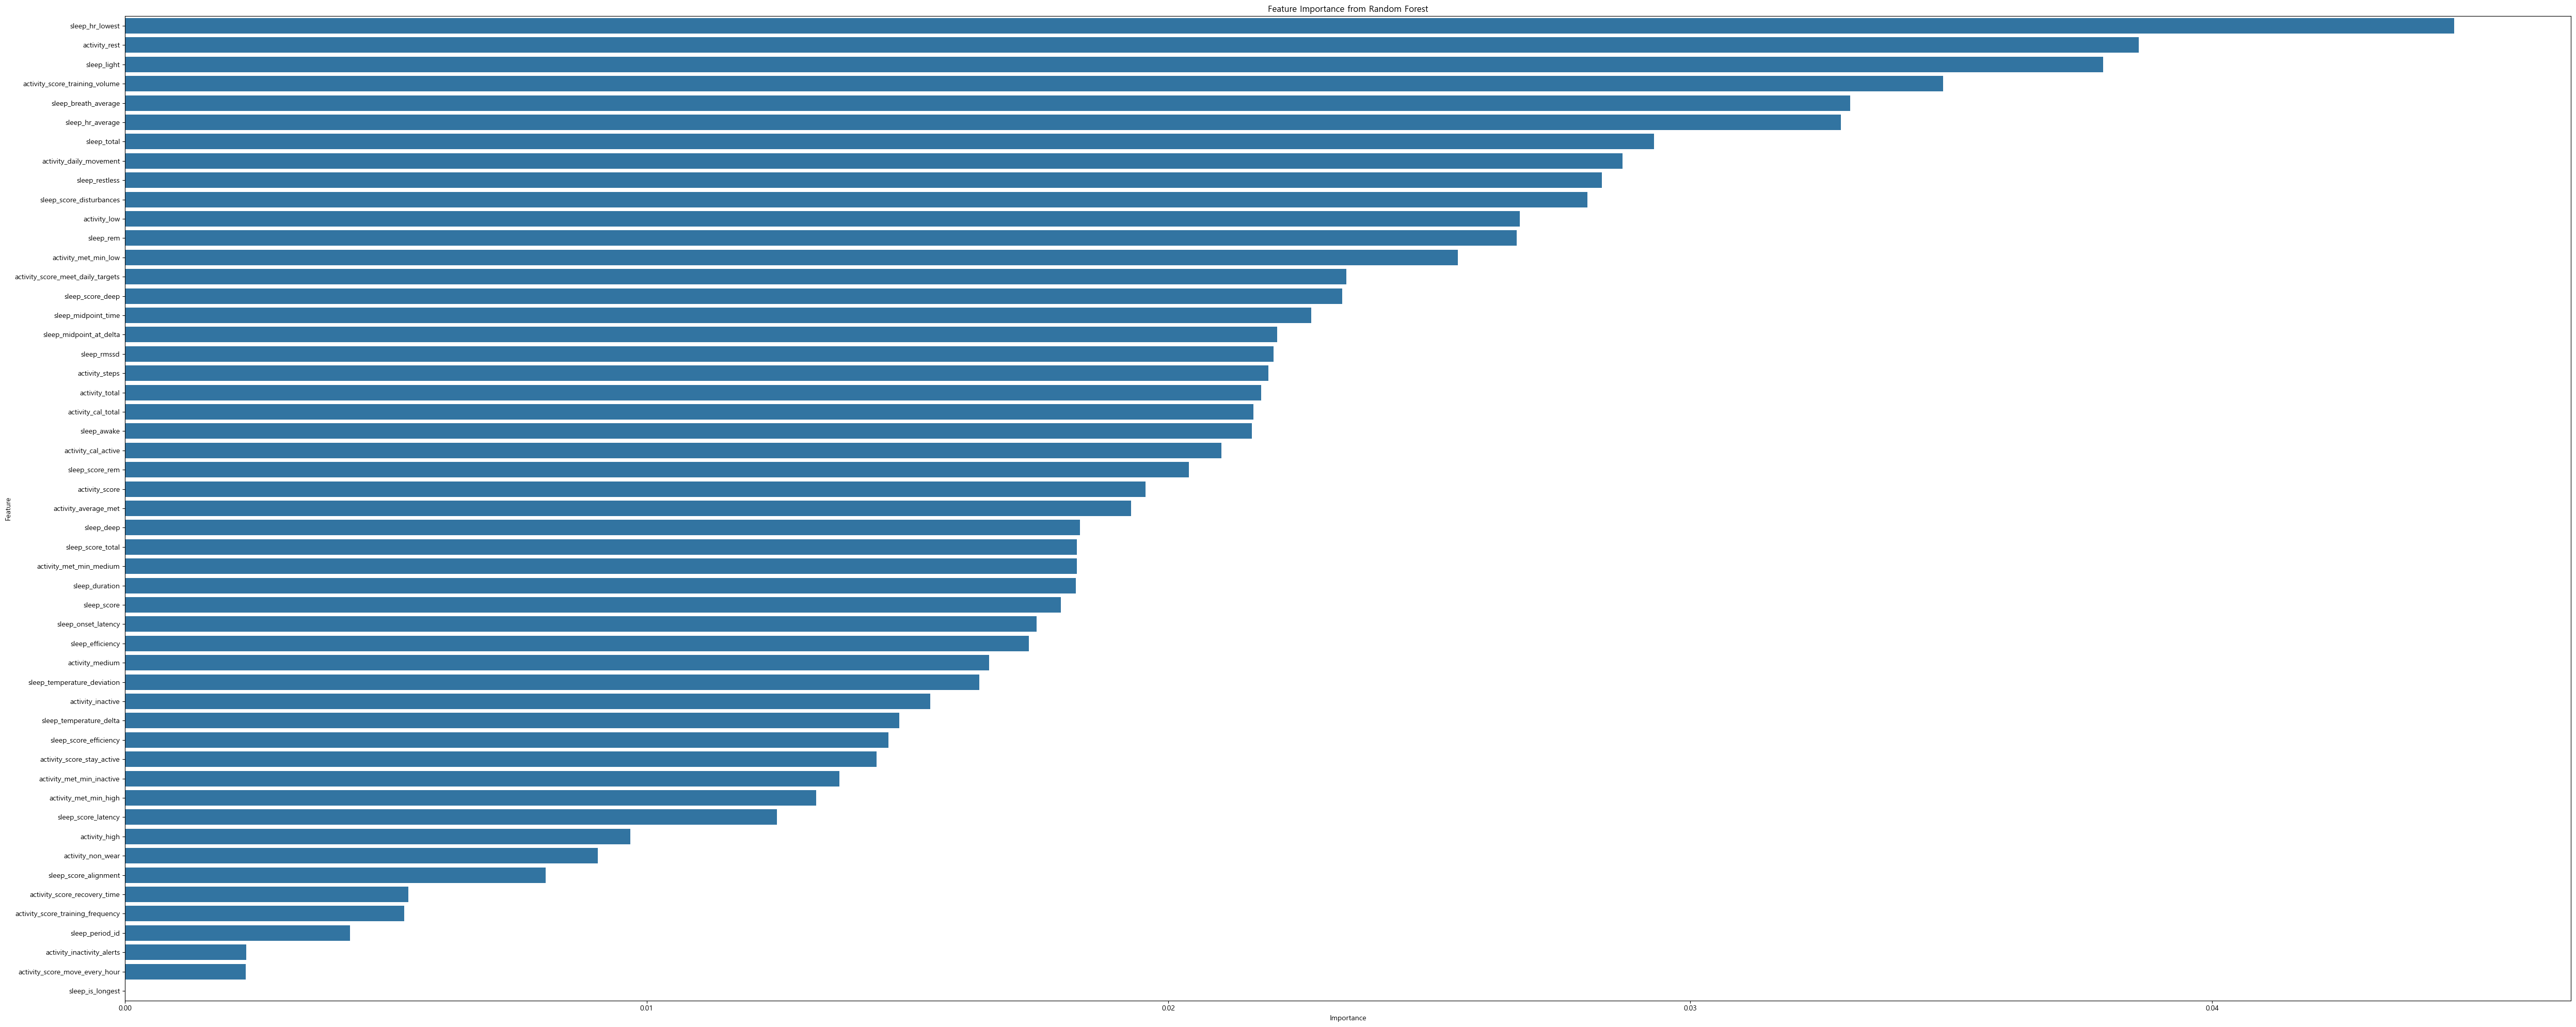

Validation Accuracy: 0.93


In [128]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = train.drop(columns=['target', 'number'])
y_train = train['target']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(50, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = test.drop(columns=['target', 'number'])
y_val = test['target']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

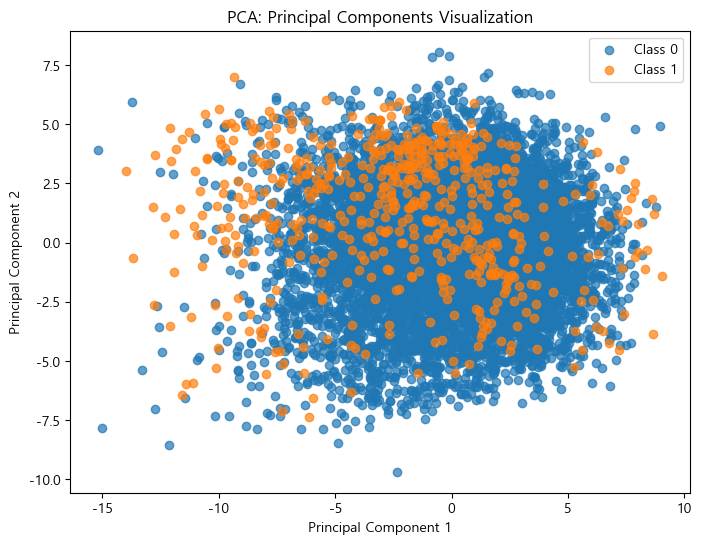

Explained Variance Ratio: [0.22440585 0.13125616]


In [129]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [130]:
top_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_features)

Top 10 Features: ['sleep_hr_lowest', 'activity_rest', 'sleep_light', 'activity_score_training_volume', 'sleep_breath_average', 'sleep_hr_average', 'sleep_total', 'activity_daily_movement', 'sleep_restless', 'sleep_score_disturbances']


In [131]:
X_train = train[top_features]
y_train = train["target"]
X_test = test[top_features]
y_test = test["target"]

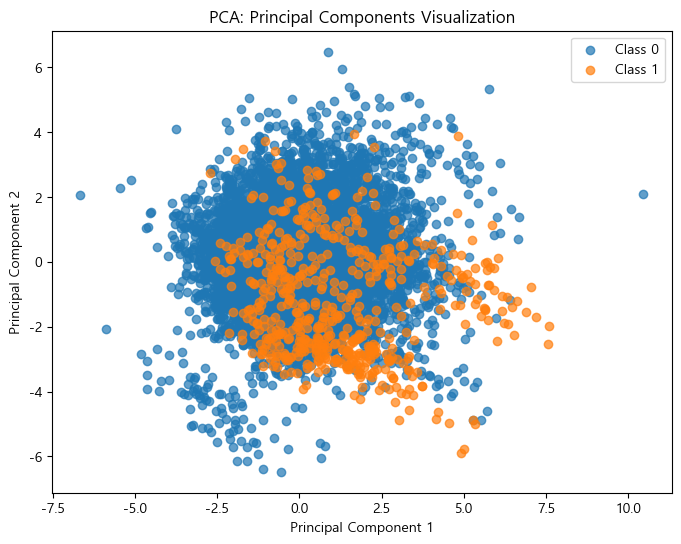

Explained Variance Ratio: [0.2460033  0.21635306]


In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

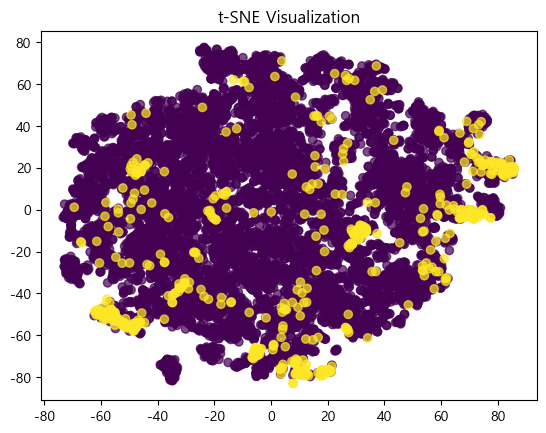

In [133]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.show()

In [137]:
cols_minmax = [col for col in top_features if col in activity_cols_minmax or col in sleep_cols_minmax]
cols_robust = [col for col in top_features if col in activity_cols_robust or col in sleep_cols_robust]
print(cols_minmax)
print(cols_robust)

['sleep_light', 'sleep_total']
['sleep_hr_lowest', 'activity_rest', 'activity_score_training_volume', 'sleep_breath_average', 'sleep_hr_average', 'activity_daily_movement', 'sleep_restless', 'sleep_score_disturbances']


In [138]:
sc_minmax = MinMaxScaler()
sc_robust = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_minmax] = sc_minmax.fit_transform(X_train[cols_minmax])
X_test_scaled[cols_minmax] = sc_minmax.transform(X_val[cols_minmax])

X_train_scaled[cols_robust] = sc_robust.fit_transform(X_train[cols_robust])
X_test_scaled[cols_robust] = sc_robust.transform(X_test[cols_robust])


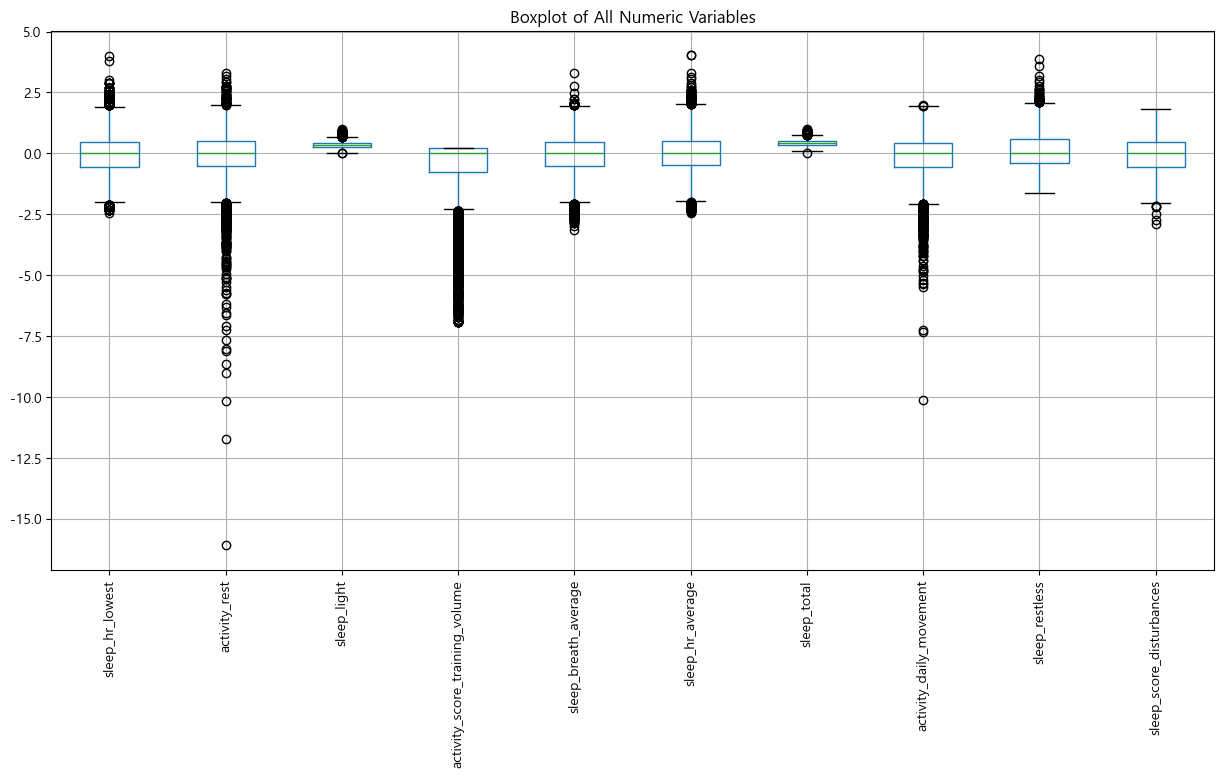

In [139]:
plt.figure(figsize=(15, 7))  # 그래프 크기 설정
X_train_scaled.boxplot()  # 모든 숫자형 열에 대한 박스플롯 생성
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title('Boxplot of All Numeric Variables')  # 그래프 제목
plt.show()  # 그래프 표시

In [141]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_scaled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.170743
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9694
Method:                           MLE   Df Model:                           10
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.2369
Time:                        14:59:33   Log-Likelihood:                -1657.1
converged:                       True   LL-Null:                       -2171.5
Covariance Type:            nonrobust   LLR p-value:                1.117e-214
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.0941      0.192    -26.519     

- 로지스틱 회귀

In [142]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_scaled, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8454398708635997
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      2264
           1       0.33      0.73      0.45       214

    accuracy                           0.85      2478
   macro avg       0.65      0.79      0.68      2478
weighted avg       0.92      0.85      0.87      2478

Confusion Matrix:
 [[1938  326]
 [  57  157]]


- 나이브 베이즈

In [143]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test_scaled)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9564164648910412
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2264
           1       0.81      0.65      0.72       214

    accuracy                           0.96      2478
   macro avg       0.89      0.82      0.85      2478
weighted avg       0.95      0.96      0.95      2478

Confusion Matrix:
 [[2231   33]
 [  75  139]]


- XGBoost

In [144]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9261501210653753
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2264
           1       0.88      0.17      0.28       214

    accuracy                           0.93      2478
   macro avg       0.90      0.58      0.62      2478
weighted avg       0.92      0.93      0.90      2478

Confusion Matrix:
 [[2259    5]
 [ 178   36]]


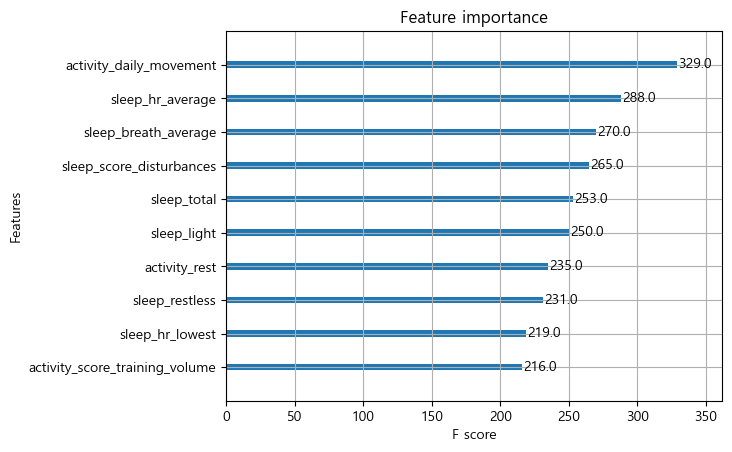

In [145]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [146]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=200,learning_rate=0.01,random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_scaled, y_train)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 571, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.9253430185633575
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2264
           1       0.57      0.59      0.58       214

    accuracy                           0.93      2478
   macro avg       0.76      0.77      0.77      2478
weighted avg       0.93      0.93      0.93      2478

Confusion Matrix:
 [[2167   97]
 [  88  126]]


- Decision Tree

In [147]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test_scaled)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9035512510088781
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      2264
           1       0.24      0.06      0.09       214

    accuracy                           0.90      2478
   macro avg       0.58      0.52      0.52      2478
weighted avg       0.86      0.90      0.87      2478

Confusion Matrix:
 [[2227   37]
 [ 202   12]]


4. activity + sleep + SMOTE적용 으로 학습

In [148]:
X_train = train[top_features]
y_train = train["target"]
X_test = test[top_features]
y_test = test["target"]

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (9705, 10) (9705,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (18268, 10) (18268,)
SMOTE 적용 후 레이블 값 분포: 
 target
0    9134
1    9134
Name: count, dtype: int64


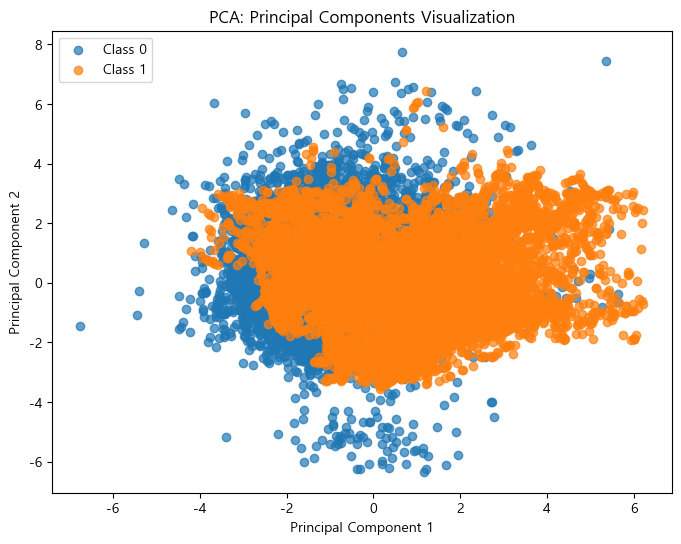

Explained Variance Ratio: [0.30992942 0.24774382]


In [149]:
# SMOTE로 학습된 데이터 (X_train_over, y_train_over)를 표준화
scaler = StandardScaler()
X_train_over_scaled = scaler.fit_transform(X_train_over)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_over_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_train_over.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [151]:
X_train_scaled = X_train_over.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_minmax] = sc_minmax.fit_transform(X_train_over[cols_minmax])
X_test_scaled[cols_minmax] = sc_minmax.transform(X_test[cols_minmax])

X_train_scaled[cols_robust] = sc_robust.fit_transform(X_train_over[cols_robust])
X_test_scaled[cols_robust] = sc_robust.transform(X_test[cols_robust])

In [152]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_scaled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train_over, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.466558
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                18268
Model:                          Logit   Df Residuals:                    18257
Method:                           MLE   Df Model:                           10
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.3269
Time:                        15:07:15   Log-Likelihood:                -8523.1
converged:                       True   LL-Null:                       -12662.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.2334      0.076    -16.296     

- 로지스틱 회귀

In [153]:
# 로지스틱 회귀 모델 초기화 및 학습
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_scaled, y_train_over)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8490718321226796
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      2264
           1       0.33      0.71      0.45       214

    accuracy                           0.85      2478
   macro avg       0.65      0.79      0.68      2478
weighted avg       0.91      0.85      0.87      2478

Confusion Matrix:
 [[1951  313]
 [  61  153]]


- 나이브 베이즈

In [154]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_over)

# 예측
y_pred_nb = nb_model.predict(X_test_scaled)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8490718321226796
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2264
           1       0.34      0.83      0.49       214

    accuracy                           0.85      2478
   macro avg       0.66      0.84      0.70      2478
weighted avg       0.93      0.85      0.87      2478

Confusion Matrix:
 [[1927  337]
 [  37  177]]


- XGBoost

In [155]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_over)

# 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9217110573042776
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      2264
           1       0.57      0.37      0.45       214

    accuracy                           0.92      2478
   macro avg       0.76      0.67      0.70      2478
weighted avg       0.91      0.92      0.91      2478

Confusion Matrix:
 [[2205   59]
 [ 135   79]]


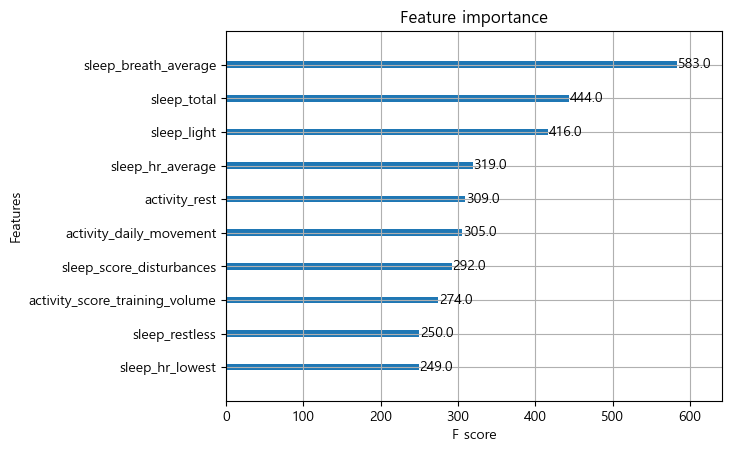

In [156]:
plot_importance(xgb_model)
plt.show()

- LightGBM

In [157]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=50,learning_rate=0.01,random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_scaled, y_train_over)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 9134, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 18268, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8648103309120259
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      2264
           1       0.35      0.68      0.46       214

    accuracy                           0.86      2478
   macro avg       0.66      0.78      0.69      2478
weighted avg       0.91      0.86      0.88      2478

Confusion Matrix:
 [[1998  266]
 [  69  145]]


- Decision Tree

In [158]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(splitter='random',random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train_over)

# 예측
y_pred_dt = dt_model.predict(X_test_scaled)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8466505246166263
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      2264
           1       0.27      0.47      0.34       214

    accuracy                           0.85      2478
   macro avg       0.61      0.67      0.63      2478
weighted avg       0.89      0.85      0.86      2478

Confusion Matrix:
 [[1998  266]
 [ 114  100]]


5. activity + sleep + BorderlineSMOTE적용 으로 학습

In [161]:
X_train = train[top_features]
y_train = train["target"]
X_test = test[top_features]
y_test = test["target"]

# Borderline-SMOTE 적용
borderline_smote = BorderlineSMOTE(kind='borderline-1', random_state=42)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)

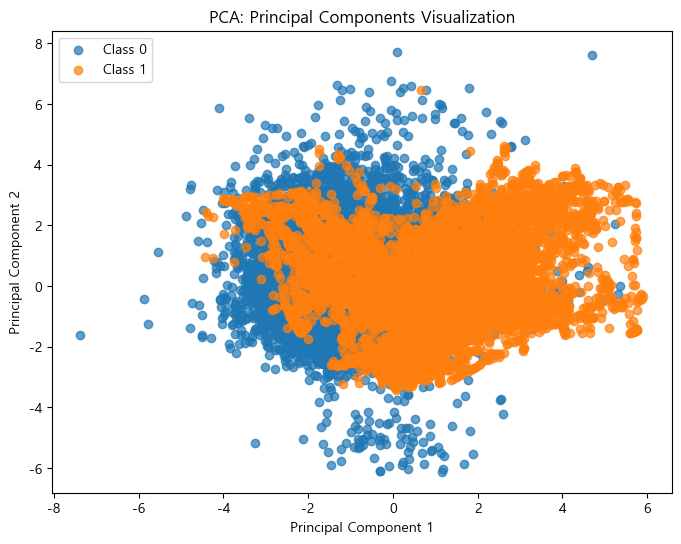

Explained Variance Ratio: [0.32291061 0.25033489]


In [162]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)

# PCA 수행
pca = PCA(n_components=2)  # 주요 2개의 성분으로 차원 축소
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Target'] = y_resampled.values  # 타겟 레이블 추가

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
for target in pca_df['Target'].unique():
    indices = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices, 'Principal Component 1'],
                pca_df.loc[indices, 'Principal Component 2'],
                label=f'Class {target}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Principal Components Visualization')
plt.legend()
plt.show()

# PCA 설명 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

In [163]:
X_train_scaled = X_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_minmax] = sc_minmax.fit_transform(X_resampled[cols_minmax])
X_test_scaled[cols_minmax] = sc_minmax.transform(X_test[cols_minmax])

X_train_scaled[cols_robust] = sc_robust.fit_transform(X_resampled[cols_robust])
X_test_scaled[cols_robust] = sc_robust.transform(X_test[cols_robust])

- 로지스틱 회귀

In [164]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_scaled)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_resampled, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.392789
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                18268
Model:                          Logit   Df Residuals:                    18257
Method:                           MLE   Df Model:                           10
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.4333
Time:                        15:16:59   Log-Likelihood:                -7175.5
converged:                       True   LL-Null:                       -12662.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.0475      0.091    -22.436     

In [165]:
# 로지스틱 회귀 모델 초기화 및 학습
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_scaled, y_resampled)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8813559322033898
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      2264
           1       0.39      0.68      0.50       214

    accuracy                           0.88      2478
   macro avg       0.68      0.79      0.71      2478
weighted avg       0.92      0.88      0.90      2478

Confusion Matrix:
 [[2039  225]
 [  69  145]]


- 나이브 베이즈

In [170]:
# 나이브 베이즈 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_resampled)

# 예측
y_pred_nb = nb_model.predict(X_test_scaled)

# 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8716707021791767
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      2264
           1       0.38      0.80      0.52       214

    accuracy                           0.87      2478
   macro avg       0.68      0.84      0.72      2478
weighted avg       0.93      0.87      0.89      2478

Confusion Matrix:
 [[1988  276]
 [  42  172]]


<Axes: >

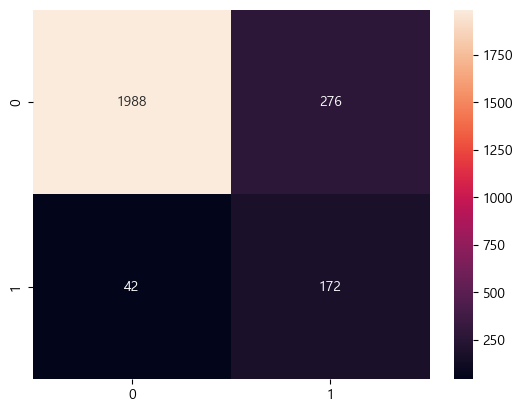

In [171]:
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d')

- XGBoost

In [167]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_resampled)

# 예측
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 평가
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9265536723163842
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2264
           1       0.65      0.32      0.43       214

    accuracy                           0.93      2478
   macro avg       0.79      0.65      0.70      2478
weighted avg       0.91      0.93      0.92      2478

Confusion Matrix:
 [[2227   37]
 [ 145   69]]


- LightGBM

In [168]:
# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_estimators=50,learning_rate=0.1,random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_scaled, y_resampled)

# 예측
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 평가
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 9134, number of negative: 9134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 18268, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.9289749798224375
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      2264
           1       0.63      0.43      0.51       214

    accuracy                           0.93      2478
   macro avg       0.79      0.70      0.74      2478
weighted avg       0.92      0.93      0.92      2478

Confusion Matrix:
 [[2211   53]
 [ 123   91]]


- Decision Tree

In [169]:
# 결정 트리 모델 학습
dt_model = DecisionTreeClassifier(criterion="entropy",splitter='random',random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_resampled)

# 예측
y_pred_dt = dt_model.predict(X_test_scaled)

# 평가
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8680387409200968
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2264
           1       0.28      0.33      0.30       214

    accuracy                           0.87      2478
   macro avg       0.61      0.63      0.61      2478
weighted avg       0.88      0.87      0.87      2478

Confusion Matrix:
 [[2080  184]
 [ 143   71]]
